In [1]:
import os
import numpy as np
import mne
import imageio
import h5py
# import scipy.fftpack
import matplotlib
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns
# import scipy.io as sio
# from scipy.integrate import simps
import pandas as pd
# from scipy import fft
import matplotlib.mlab as mlab
import sys
import matplotlib as mpl
sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis\py_functions')
import NMF_funcs as NMFf

from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath

root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat
import scipy.cluster.hierarchy as spc
from scipy.spatial import distance
from sklearn.cluster import KMeans
import h5py
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
#import IO_func as IOF
#import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab
import BM_plots as BMp
import freq_funcs as ff
import CCEP_plot
regions = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\elab_labels.xlsx", sheet_name='regions', header=0)
color_regions = regions.color.values
regions = regions.label.values

CR_color = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\Analysis\BrainMapping\CR_color.xlsx", header=0)
CR_color_a = CR_color.a.values
CR_color = CR_color.c.values
CR_color = np.zeros((24, 3))
CR_color[6:18, :] = np.array([253, 184, 19]) / 255

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()

In [2]:
color_sleep = ['#808080', '#145da0', '#ff1919']
label_sleep = ['Wake', 'NREM', 'REM']
color_dist = ['0000FF','#0076C4','#00DD91']

In [3]:
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'
if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

## Cluster to Analysis

In [4]:
def compare_distributions(dist1, dist2):
    """
    Compare two distributions using Wilcoxon signed-rank test.
    Return +1 if the median of dist2 is significantly greater than that of dist1,
    -1 if it's significantly smaller, 0 otherwise.
    """
    stat, p = scipy.stats.kruskal(dist1, dist2)
    #print(p)
    if p < 0.001:
        
        return 1 if np.median(dist2) > np.median(dist1) else -1
    else:
        return 0

In [5]:
def get_sleep_effect(con_trial, con_summary, metric = 'LL_norm'):
    clusters = con_trial['Cluster'].unique()
        # Iterate over clusters
    for cluster in clusters:
        # Get unique Stim and Chan combinations for the current cluster
        data_cluster = con_trial.loc[con_trial['Cluster'] == cluster]
        #print(cluster)
        # Compare distributions of LL_onset_norm between Wake and NREM
        nrem = compare_distributions(data_cluster[data_cluster.SleepState == 'Wake'][metric].values, data_cluster[data_cluster.SleepState == 'NREM'][metric].values)
        # Compare distributions of LL_onset_norm between Wake and REM
        rem = compare_distributions(data_cluster[data_cluster.SleepState == 'Wake'][metric].values, data_cluster[data_cluster.SleepState == 'REM'][metric].values)

        con_summary.loc[con_summary['Cluster'] == cluster, 'NREM_Effect'] = nrem
        con_summary.loc[con_summary['Cluster'] == cluster, 'REM_Effect'] = rem
    return con_summary

In [6]:
path_gen_base = sub_path + '\Patients'

In [7]:
subj = "EL027"
path_patient_analysis = os.path.join(sub_path, 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', subj)

path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_gen, 'Electrodes')
# labels
files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\stimlist_' + cond_folder + '.csv'
stimlist = pd.read_csv(stimlist_file)
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
if "type" in lbls.columns:
    lbls = lbls[lbls.type=='SEEG']
    lbls = lbls.reset_index(drop=True)
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)
stimlist_sleep = pd.read_csv(os.path.join(path_patient_analysis, 'stimlist_hypnogram.csv'))
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
con_trial = pd.read_csv(file_con)
badchans = pd.read_csv(path_patient_analysis + '/BrainMapping/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1:] == 1))[0, :])

In [8]:
h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    EEG_resp = h5py.File(h5_file)
    EEG_resp = EEG_resp['EEG_resp']
print(EEG_resp.shape)
print(len(stimlist))
print(np.max(con_trial.Num)+1)

loading h5
(112, 32402, 2000)
32402
32402


In [9]:
con_trial = bf.add_sleepstate(con_trial)

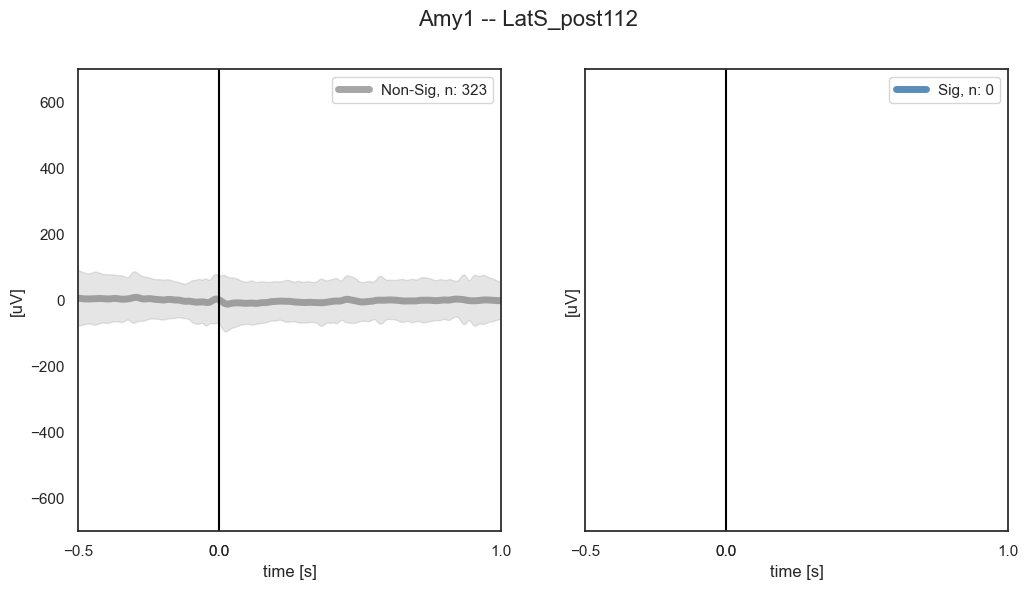

In [25]:
axes = CCEP_plot.plot_Sig(0,111, EEG_resp, con_trial[con_trial.Artefact<1], labels_all)
axes[0].set_ylim([-700,700])
plt.show()

In [26]:
parameters=['Sig', 'd', 'delay']
cluster_method = 'similarity'
file_CC_summ = path_patient_analysis + '\\' + folder + '\\data\\CC_summ_' + cluster_method + '.csv'

CC_summ = pd.read_csv(file_CC_summ)
CC_summ = CC_summ[(CC_summ.sig >0.5)]
CC_summ = CC_summ.groupby(['Stim', 'Chan'], as_index=False)[['t_WOI']].mean()
file_CC_summ = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\summ_general.csv'  # summary_genera
con_summary_all = pd.read_csv(file_CC_summ)

con_summary = con_summary_all[(con_summary_all.Sig > 0)].reset_index(drop=True)
con_summary_short = con_summary[(np.isin(con_summary.Stim, np.unique(con_summary.Chan)))&(np.isin(con_summary.Chan, np.unique(con_summary.Stim)))].reset_index(drop=True)
con_summary_short = con_summary_short.groupby(['Stim', 'Chan'], as_index=False)[parameters].mean().reset_index(drop=True)

print(EEG_resp.shape)
print(len(stimlist))
print(np.max(con_trial.Num)+1)

loading h5
(112, 32402, 2000)
32402
32402


In [27]:
con_summary = con_summary_all[(con_summary_all.Sig > 0)].reset_index(drop=True)
con_summary_short = con_summary[(np.isin(con_summary.Stim, np.unique(con_summary.Chan)))&(np.isin(con_summary.Chan, np.unique(con_summary.Stim)))].reset_index(drop=True)
con_summary_short = con_summary_short.groupby(['Stim', 'Chan'], as_index=False)[parameters].mean().reset_index(drop=True)


In [ ]:
stop

# NMF on subset of connections

## Hard clustering

In [ ]:
import NMF_funcs as nmf
import sklearn
import re

### distance & delay

In [ ]:
con_trial.insert(0,'Con_ID',con_trial.groupby(['Stim', 'Chan']).ngroup())
con_trial['LL_sig'] = con_trial['LL']*con_trial['Sig']

In [ ]:
con_summary.insert(0, 'Con_group', 'local')
con_summary.loc[(con_summary.d>20)&(con_summary.delay>0.02), 'Con_group'] = 'indirect'
con_summary.loc[(con_summary.d>20)&(con_summary.delay<0.02), 'Con_group'] = 'direct'

In [ ]:
con_trial_grouped = con_trial.merge(con_summary[['Stim', 'Chan', 'Con_group', 'StimR', 'ChanR']], on = ['Stim', 'Chan'], how ='left')

In [ ]:
con_trial_grouped = con_trial_grouped[~np.isin(con_trial_grouped.Chan, bad_chans)&(con_trial_grouped.Ictal==0)&(con_trial_grouped.LL<50)&(con_trial_grouped.P2P<6000)&(con_trial_grouped.Artefact<1)&(con_trial_grouped.Sig>-1)].reset_index(drop=True)

#con_trial['LL_ratio'] = con_trial['LL']/con_trial['LL_pre']

In [ ]:
exp_dir = os.path.join(path_patient_analysis, 'BrainMapping', 'CR', 'NMF','subnetwork_features')
cond_folder = 'CR'
os.makedirs(exp_dir, exist_ok=True) 

In [ ]:

m = 'LL_sig' #m+'_BL'
data_plot = con_trial_grouped.groupby(['Con_ID','Con_group', 'Stim', 'Chan','StimR', 'ChanR', 'Block'], as_index=False)[[m, 'Sig']].mean().reset_index(drop=True)


In [ ]:
group_sel = 'direct'
title = group_sel +' connections'
df_pivot = data_plot[data_plot.Con_group == group_sel].pivot(index='Con_ID', columns='Block', values=m)
df_pivot = df_pivot.apply(lambda row: row.fillna(row.mean()), axis=1) 
df_pivot = df_pivot.fillna(df_pivot.median(axis=0)) 
V = df_pivot.values
V = sklearn.preprocessing.normalize(V,axis = 1)
plt.pcolormesh(V)
plt.ylabel(group_sel +' connections')
plt.xlabel('Stimulation Block')
plt.title('NMF Input LL value')

In [ ]:
nmf.parallel_nmf_consensus_clustering(V.T, [1,4], 50, experiment_dir=exp_dir, target_clusters=None)

metric = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
k = metric.loc[(metric['Instability index'] == np.min(metric['Instability index'])), 'Rank'].values[0]
H = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'H_best.csv'), header=None).values
W = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'W_best.csv'), header=None).values
plot_H_hypnogram(H, con_trial, stimlist_sleep)
plt.suptitle(title)

### ANATOMY

In [ ]:
stim = 'Temporal'
resp = 'Insula'
group_sel = stim + '-'+resp
title = group_sel +' connections'
df_pivot = data_plot[(data_plot.StimR == stim)&(data_plot.ChanR == resp)].pivot(index='Con_ID', columns='Block', values=m)
df_pivot = df_pivot.apply(lambda row: row.fillna(row.mean()), axis=1) 
df_pivot = df_pivot.fillna(df_pivot.median(axis=0)) 
V = df_pivot.values
V = sklearn.preprocessing.normalize(V,axis = 1)
plt.pcolormesh(V)
plt.ylabel(title)
plt.xlabel('Stimulation Block')
plt.title('NMF Input LL value')

In [ ]:
nmf.parallel_nmf_consensus_clustering(V.T, [2,3], 50, experiment_dir=exp_dir, target_clusters=None)

metric = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
k = metric.loc[(metric['Instability index'] == np.min(metric['Instability index'])), 'Rank'].values[0]
H = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'H_best.csv'), header=None).values
W = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'W_best.csv'), header=None).values
plot_H_hypnogram(H, con_trial, stimlist_sleep)
plt.suptitle(title)

## NMF clustering

### Euclidean distance

In [ ]:
con_summary[con_summary.Sig >0]

In [ ]:
df_pivot = con_summary[(np.isin(con_summary.Stim, np.unique(con_summary.Chan)))&(np.isin(con_summary.Chan, np.unique(con_summary.Stim)))].groupby(['Stim', 'Chan'], as_index=False)[m_cluster].mean()
nodes_important = np.unique(df_pivot.Stim)
df_pivot[m_cluster] = 1/df_pivot[m_cluster]
df_pivot = df_pivot.pivot(index='Stim', columns='Chan', values=m_cluster)
df_pivot = df_pivot.fillna(0) 
V = df_pivot.values
plt.pcolormesh(V)
plt.title('NMF Input LL value')

In [ ]:
n_node_total = len(labels_all)
M_V = np.zeros((n_node_total, n_node_total))
# Explicitly select the submatrix
rows_idx = nodes_important[:, np.newaxis]
cols_idx = nodes_important

M_V[rows_idx, cols_idx] = V

In [ ]:
fig = plt.figure(figsize=(10,10))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM(M_V, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1)
plt.title('BM based on 1/d (closeness)')

In [ ]:
n_node_total = len(labels_all)
n_cluster = W.shape[1]
nodes_important = np.unique(con_summary.Stim).astype('int')

# Initialize matrices
M_W = np.zeros((n_node_total, n_cluster))
M_H = np.zeros((n_cluster, n_node_total))
M_V = np.zeros((n_node_total, n_node_total))

# Assign values
M_W[nodes_important, :] = W
M_H[:, nodes_important] = H
# Explicitly select the submatrix
rows_idx = nodes_important[:, np.newaxis]
cols_idx = nodes_important

M_V[rows_idx, cols_idx] = V

fig = plt.figure(figsize=(10,10))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM(M_V, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1)

fig = plt.figure(figsize=(4, 10))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM_coeff(M_W, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1, orientation =0)

fig = plt.figure(figsize=(10,4))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM_coeff(M_H, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1, orientation =1)


In [ ]:
group_sel = 'direct'
title = group_sel +' connections'
df_pivot = data_plot[data_plot.Con_group == group_sel].pivot(index='Con_ID', columns='Block', values=m)
df_pivot = df_pivot.apply(lambda row: row.fillna(row.mean()), axis=1) 
df_pivot = df_pivot.fillna(df_pivot.median(axis=0)) 
V = df_pivot.values
V = sklearn.preprocessing.normalize(V,axis = 1)
plt.pcolormesh(V)
plt.ylabel(group_sel +' connections')
plt.xlabel('Stimulation Block')
plt.title('NMF Input LL value')

# Plots


In [ ]:
def plot_wake_trials(sc, rc, con_trial):
    lists = con_trial[(con_trial['Chan'] == rc) & (con_trial['Stim'] == sc)]
    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style='white')
    plt.title(labels_all[sc] + ' -- ' + labels_all[rc], fontsize=30)
    ylim = 300

        #fig.add_subplot(gs[0, sig])
    #gs = fig.add_gridspec(1,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for sig, sig_lab in zip([0,1,2],['Wake', 'NREM', 'REM']):
        stimnum = lists.loc[(lists.SleepState==sig_lab),'Num'].values.astype('int')
        #fig.add_subplot(gs[0, sig])
        # for i in range(len(stimnum)):
        #    plt.plot(x_ax, EEG_CR[rc, stimnum[i],:], color=color_elab[0], alpha=0.5)
        mn = ff.lp_filter(np.mean(EEG_resp[rc, stimnum,:],0),30,Fs)
        # st= np.std(EEG_resp[rc, stimnum,:],0)
        plt.plot(x_ax, mn, color=color_elab[sig], linewidth=5, alpha=0.7, label=sig_lab+', n: '+str(len(stimnum)))
        # st= np.std(ff.lp_filter(trials,30,Fs),0)
        # plt.fill_between(x_ax,mn-st, mn+st,color=color_elab[sig*2], alpha=0.2 )
    plt.xticks([-0.5, 0,0., 1], fontsize=20)
    # plt.yticks([-400, 0, 400], fontsize=20)
    plt.xlabel('time [s]', fontsize=25)
    plt.ylabel('[uV]', fontsize=25)
    plt.legend( fontsize=20)
    plt.axvline(0, color=[0,0,0], label='stim')
        # plt.text(-0.3, 500, 'n: '+str(len(stimnum)), fontsize=20)
        #plt.title('Mean Across All Trials', fontsize=25)
    plt.xlim([-0.5, 1])
    plt.ylim([-ylim,ylim])
    plt.show()

In [ ]:
if not 'SleepState' in con_trial:
    con_trial.insert(6, 'SleepState', 'Wake')
con_trial.loc[(con_trial.SleepState == 'W'), 'SleepState'] = 'Wake'
con_trial.loc[(con_trial.Sleep == 0), 'SleepState'] = 'Wake'
con_trial.loc[(con_trial.Sleep > 1) & (con_trial.Sleep < 4), 'SleepState'] = 'NREM'
con_trial.loc[(con_trial.Sleep == 1), 'SleepState'] = 'NREM1'
con_trial.loc[(con_trial.Sleep == 6), 'SleepState'] = 'SZ'
con_trial.loc[(con_trial.Sleep == 4), 'SleepState'] = 'REM'

In [ ]:
sc = 18
rc = 0
plot_wake_trials(sc, rc, con_trial)

In [ ]:
norm = 0
if norm:
    m = 'LL'
    con_trial[m+'_BL'] = con_trial.groupby('Chan').apply(
            lambda x: x[m] / x['LL_pre'].median()).reset_index(0, drop=True)

In [ ]:
con_trial.insert(5, 'zLL', con_trial.groupby(['Con_ID', 'Sleep'])['LL'].transform(lambda x: (x - x.mean()) / x.std()))

In [ ]:
con_trial.loc[(con_trial.Artefact <1)&(con_trial.P2P>10000), 'Artefact'] = 2

In [ ]:
art_table = con_trial[(con_trial.Artefact <1)&(con_trial.zLL>10)].reset_index(drop=True)# con_trial[(con_trial.Artefact<1)&(con_trial.zLL>5)].reset_index(drop=True)
k = -1

In [ ]:
k = k+1
sc = art_table.Stim.values[k].astype('int')
rc = art_table.Chan.values[k].astype('int')
num = art_table.Num.values[k].astype('int')
plt.title(str(np.round(art_table.zLL.values[k],2)))
plt.plot(x_ax, EEG_resp[rc, num, :])
print(np.round(art_table.LL_pre.values[k],2))
print(np.round(art_table.P2P.values[k],2))
print(np.round(art_table.Artefact.values[k],2))

In [ ]:
m = 'LL_sig' #m+'_BL'
data_plot = con_trial[(con_trial.Artefact<1)&(con_trial.Sig>-1)].groupby(['Con_ID','Stim', 'Chan', 'Block'], as_index=False)[[m, 'Sig']].mean().reset_index(drop=True)

sig_con = data_plot.groupby(['Con_ID'], as_index=False)['Sig'].mean()
sig_con = sig_con.loc[(sig_con.Sig>0), 'Con_ID'].values
data_plot = data_plot[np.isin(data_plot.Con_ID, sig_con)].reset_index(drop=True)
con_IDs = np.unique(data_plot.Con_ID)

In [ ]:
m = 'LL_sig' #m+'_BL'
data_plot = con_trial[(con_trial.Artefact<1)&(con_trial.Sig>-1)].groupby(['Con_ID','Stim', 'Chan', 'Block'], as_index=False)[[m, 'Sig']].mean().reset_index(drop=True)

sig_con = data_plot.groupby(['Con_ID'], as_index=False)['Sig'].mean()
sig_con = sig_con.loc[(sig_con.Sig>0), 'Con_ID'].values
data_plot = data_plot[np.isin(data_plot.Con_ID, sig_con)].reset_index(drop=True)
con_IDs = np.unique(data_plot.Con_ID)

df_pivot = data_plot.pivot(index='Con_ID', columns='Block', values=m)
df_pivot = df_pivot.apply(lambda row: row.fillna(row.mean()), axis=1) 
df_pivot = df_pivot.fillna(df_pivot.median(axis=0)) 
V = df_pivot.values
if L2:
    V = sklearn.preprocessing.normalize(V,axis = 1)
    title = m+' (L2 norm)'
plt.pcolormesh(V)
plt.ylabel('Connection')
plt.ylabel('Stimulation Block')
plt.title(title)

In [ ]:
exp_dir = os.path.join(path_patient_analysis, 'BrainMapping', 'CR', 'NMF','subnetwork')
nmf.parallel_nmf_consensus_clustering(V.T, [4,4], 50, experiment_dir=exp_dir, target_clusters=None)

metric = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
k = metric.loc[(metric['Instability index'] == np.min(metric['Instability index'])), 'Rank'].values[0]
H = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'H_best.csv'), header=None).values
W = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'W_best.csv'), header=None).values

### Plot W

In [ ]:
def assgin_cluster(V, H):
    # Compute the correlation between each row in V and each row in H
    # Reshape V and H for broadcasting
    V_reshaped = V[:, :, None]
    H_reshaped = H.T[None, :, :]

    # Compute the dot products and the norms
    dot_products = np.sum(V_reshaped * H_reshaped, axis=1)
    V_norms = np.linalg.norm(V, axis=1)[:, None]
    H_norms = np.linalg.norm(H, axis=1)

    # Compute the correlation coefficients
    correlations = dot_products / (V_norms * H_norms)

    # Find the index of the row in H with which each row in V is most similar
    most_similar_rows = np.argmax(correlations, axis=1)

    return most_similar_rows

In [ ]:
Wmax =assgin_cluster(V, H)# np.argmax(W,1) 
BM_W = np.zeros((len(labels_all),len(labels_all)))-1
for w_ix in range(H.shape[0]):
    for con_ix, con in enumerate(con_IDs):
        if Wmax[con_ix] == w_ix:
            #  coeff = W[con_ix, w_ix]
            sc = data_plot.loc[data_plot.Con_ID == con, 'Stim'].values[0].astype('int')
            rc = data_plot.loc[data_plot.Con_ID == con, 'Chan'].values[0].astype('int')
            BM_W[sc, rc] = w_ix
print(np.unique(BM_W))
# mask some 'bad' data, in your case you would have: data == 0
BM_W = np.ma.masked_where(BM_W ==-1, BM_W)

# cmap = plt.cm.OrRd

# for mpl 3.3 and higher use
cmap = matplotlib.colormaps["Dark2"] #mpl.cm.get_cmap("Dark2").copy()
cmap.set_bad(color='black')
fig = plt.figure(figsize=(10,10))
plt.suptitle('Clusters - Highest Pearson')
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
axmatrix.pcolormesh(BM_W)
# BMp.plot_BM(BM_W, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap=cmap, vlim=[0, H.shape[0]], sort=1)


In [ ]:
plt.pcolormesh(W, vmin = np.percentile(W,20), vmax = np.percentile(W,95))
plt.xticks([0.5, 1.5, 2.5], ['W1', 'W2', 'W3'])
#plt.xticks([0.5, 1.5, 2.5, 3.5], ['W1', 'W2', 'W3', 'W4'])
plt.ylabel('Connections')
plt.colorbar()

##### coefficients

In [ ]:
BM_W = np.zeros((len(labels_all),len(labels_all)))
w_ix = 0
for con_ix, con in enumerate(con_IDs):
    coeff = W[con_ix, w_ix]
    sc = data_plot.loc[data_plot.Con_ID == con, 'Stim'].values[0].astype('int')
    rc = data_plot.loc[data_plot.Con_ID == con, 'Chan'].values[0].astype('int')
    BM_W[sc, rc] = coeff
vlim  = [np.percentile(BM_W[0],80),np.percentile(BM_W[0],99)]

# mask some 'bad' data, in your case you would have: data == 0
BM_W = np.ma.masked_where(BM_W ==0, BM_W)

# cmap = plt.cm.OrRd

# for mpl 3.3 and higher use
cmap = mpl.cm.get_cmap("seismic").copy()
cmap.set_bad(color='black')

fig = plt.figure(figsize=(10,10))
plt.suptitle('W coefficients of Cluster '+str(w_ix+1))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM(BM_W, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap=cmap, vlim=vlim, sort=1)


### Plot H

In [ ]:
plot_H_hypnogram(H, con_trial, stimlist_sleep, cmap)
plt.suptitle(title)
# plt.ylim([0.12, 0.4])

In [ ]:
def plot_H_hypnogram(H, con_trial, stimlist_sleep):
    def format_time_hour(x, pos):
        while x > 24:
            x -= 24
        return f'{int(x):02d}:00'
    
    from matplotlib.ticker import FuncFormatter
    path_output = os.path.join(path_patient_analysis, 'BrainMapping', 'CR', 'NMF', 'figures')
    os.makedirs(path_output, exist_ok=True)  # Create directories if they don't exist
    # adding "ic_chron" which adds +24h if there is a new day to keep it chronological
    for d in range(len(np.unique(stimlist_sleep.date))):
        stimlist_sleep.loc[stimlist_sleep.date == np.unique(stimlist_sleep.date)[d], 'ix_chron'] = \
            stimlist_sleep.loc[
                stimlist_sleep.date == np.unique(stimlist_sleep.date)[d], 'ix_h'] + d * 24
    stimlist_hypno =stimlist_sleep
    stimlist_hypno.loc[stimlist_hypno.sleep > 4, 'sleep'] = 0  # everythin that's greter than 4 is also wake
    # some calculations to have the same x time axis for both plots

    rk = H.shape[0]
    n_block = H.shape[1]
    blocks_all = np.unique(con_trial.Block)
    # Generating x-axis values
    x_ax_block = np.arange(0, n_block).astype('float')
    for ix_b, b in enumerate(np.unique(con_trial.Block)):
        x_ax_block[ix_b] = np.mean(stimlist_sleep.loc[stimlist_sleep.stim_block == b, 'ix_chron'])
    # x_ticks_h = np.arange(0, np.max(blocks_all) + 1, step=5)
    # labels_hour = [f'{int(h):02d}:00' for h in np.floor(self.stimlist_sleep.ix_h[x_ticks_h])]
    timeline = np.ceil(np.max(stimlist_sleep.ix_chron) - np.min(stimlist_sleep.ix_chron)).astype('int')
    # Create figure and subplots
    fig, (ax_h, ax) = plt.subplots(2, 1, figsize=(timeline / 3.5, 7))

    # Plot hypnogram
    ax_h.plot(stimlist_sleep.ix_chron, stimlist_sleep.sleep, c='black', linewidth=2)
    ax_h.axhspan(-1, 0.2, color=color_elab[0, :])
    ax_h.fill_between(stimlist_sleep.ix_chron,stimlist_sleep.sleep, -1, color=color_elab[0, :])
    ax_h.set_yticks([0, 1, 2, 3, 4])
    ax_h.set_yticklabels(['Wake', 'N1', 'N2', 'N3', 'REM'])
    ax_h.set_ylim([-1, 5])
    ax_h.invert_yaxis()
    ax_h.set_xticks([])
    ax_h.set_ylabel('Score', fontsize=15)

    # Plot H coefficients
    for i in range(rk):
        ax.plot(x_ax_block,H[i], linewidth=4, label=f'H{i + 1}')

    # ax.set_xticks(x_ticks_h)
    # ax.set_xticklabels(labels_hour, fontsize=12)
    ax.set_ylabel('H Coefficients', fontsize=15)
    ax.set_xlabel('Time', fontsize=15)
    ax.legend(fontsize=10)
    ax.xaxis.set_major_formatter(FuncFormatter(format_time_hour))
    # same xlim as ax_h to be perfectly aligned
    ax.set_xlim(ax_h.get_xlim())

    plt.tight_layout()

### First cluster subnetworks based on P values

In [ ]:
con_trial.loc[(con_trial.Sig==-1)&(con_trial.d<7.1), 'Sig'] = 1
con_trial = con_trial[con_trial.Sig>-1].reset_index(drop=True)

In [ ]:
con_trial_clean = con_trial[(con_trial.Sig>-1)& (con_trial.Artefact<1)].reset_index(drop=True)

In [ ]:
M_p = con_trial_clean.groupby(['Stim', 'Chan'], as_index=False)[['Sig', 'd']].mean()

In [ ]:
M_p =M_p[np.isin(M_p.Chan, np.unique(M_p.Stim))].reset_index(drop=True)

In [ ]:
df_pivot = M_p.pivot(index='Stim', columns='Chan', values='Sig')
df_pivot.fillna(0, inplace=True)
V = df_pivot.values

In [ ]:
exp_dir = os.path.join(path_patient_analysis, 'BrainMapping', 'CR', 'NMF','subnetwork')
nmf.parallel_nmf_consensus_clustering(V.T, [3,10], 10, experiment_dir=exp_dir, target_clusters=None)

metric = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
k = metric.loc[(metric['Instability index'] == np.min(metric['Instability index'])), 'Rank'].values[0]
H = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'H_best.csv'), header=None).values
W = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'W_best.csv'), header=None).values



In [ ]:
n_node_total = len(labels_all)
n_cluster = W.shape[1]
nodes_important = np.unique(M_p.Stim).astype('int')

# Initialize matrices
M_W = np.zeros((n_node_total, n_cluster))
M_H = np.zeros((n_cluster, n_node_total))
M_V = np.zeros((n_node_total, n_node_total))

# Assign values
M_W[nodes_important, :] = W
M_H[:, nodes_important] = H
# Explicitly select the submatrix
rows_idx = nodes_important[:, np.newaxis]
cols_idx = nodes_important

M_V[rows_idx, cols_idx] = V

fig = plt.figure(figsize=(10,10))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM(M_V, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1)

fig = plt.figure(figsize=(4, 10))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM_coeff(M_W, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1, orientation =0)

fig = plt.figure(figsize=(10,4))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM_coeff(M_H, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1, orientation =1)


In [ ]:
fig = plt.figure(figsize=(10,10))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM(M_V, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1)

In [ ]:
fig = plt.figure(figsize=(10,4))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM_coeff(M_H, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1, orientation =1)

In [ ]:
fig = plt.figure(figsize=(4, 10))
axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])
BMp.plot_BM_coeff(M_W, labels_all, lbls.Hemisphere.values, axmatrix, axcolor=None, cmap='hot', vlim=None, sort=1, orientation =0)

In [ ]:
blocks = np.unique(con_trial.Block)
n_blocks = len(blocks)

In [ ]:
m = 'LL_sig'

In [ ]:
c = 1

thr = np.percentile(M_W[:,c],90)
stim_chans = np.where(M_W[:,c]>thr)[0]
thr = np.percentile(M_H[c,:],90)
resp_chans = np.where(M_H[c,:]>thr)[0]
data_plot = con_trial_clean.loc[np.isin(con_trial_clean.Stim, stim_chans)&np.isin(con_trial_clean.Chan, resp_chans)] 
    
df_pivot = data_plot.pivot(index='Chan', columns='Num', values=m)
df_pivot.fillna(0, inplace=True)
V = df_pivot.values
if L2:
    V = sklearn.preprocessing.normalize(V,axis = 1)
    title = 'Subnetwork '+ str(c+1)+', '+m+' (L2 norm)'
    
plt.pcolormesh(V)
plt.ylabel('REsponse channels (part of Cluster)')
plt.xlabel('Stimulation trials (only from selected stim channels)')
plt.title(title)

In [ ]:
plot_H_hypnogram(H, con_trial, stimlist_sleep)
plt.suptitle(title)
# plt.ylim([0.12, 0.4])

In [ ]:
exp_dir = os.path.join(path_patient_analysis, 'BrainMapping', 'CR', 'NMF','subnetwork')
nmf.parallel_nmf_consensus_clustering(V.T, [3,3], 2, experiment_dir=exp_dir, target_clusters=None)

metric = pd.read_csv(os.path.join(exp_dir, 'metrics.csv'))
k = metric.loc[(metric['Instability index'] == np.min(metric['Instability index'])), 'Rank'].values[0]
H = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'H_best.csv'), header=None).values
W = pd.read_csv(os.path.join(exp_dir, 'k=' + str(k), 'W_best.csv'), header=None).values



In [ ]:
V_2 = np.zeros((n_cluster,n_blocks))
# find stim / response nodes for each cluster
for c in range(n_cluster):
    thr = np.percentile(M_W[:,c],90)
    stim_chans = np.where(M_W[:,c]>thr)[0]
    thr = np.percentile(M_H[c,:],90)
    resp_chans = np.where(M_H[c,:]>thr)[0]
    data_plot = con_trial_clean.loc[np.isin(con_trial_clean.Stim, stim_chans)&np.isin(con_trial_clean.Chan, resp_chans)]
    V_2[c,:] = data_plot.groupby(['Block'])['LL'].median().values
    
    

In [ ]:
data_plot

In [ ]:
plt.pcolormesh(V_2)
plt.ylabel('Subnetworks')
plt.xlabel('Block')

In [ ]:
exp_dir2 = os.path.join(path_patient_analysis, 'BrainMapping', 'CR', 'NMF','subnetwork','k=' + str(k),'temporal_cluster')
nmf.parallel_nmf_consensus_clustering(V_2.T, [3,6], 10, experiment_dir=exp_dir2, target_clusters=None)

metric = pd.read_csv(os.path.join(exp_dir2, 'metrics.csv'))
k = metric.loc[(metric['Instability index'] == np.min(metric['Instability index'])), 'Rank'].values[0]
H = pd.read_csv(os.path.join(exp_dir2, 'k=' + str(k), 'H_best.csv'), header=None).values
W = pd.read_csv(os.path.join(exp_dir2, 'k=' + str(k), 'W_best.csv'), header=None).values



In [ ]:
W

In [ ]:
plt.pcolormesh(W, cmap = 'hot')
plt.ylabel('Subnetworks')
plt.xlabel('Temporal Cluster')

In [ ]:
for h in range(H.shape[0]):
    plt.plot(H[h], label = 'H'+str(h))
plt.legend()
plt.xlabel('BLock')

In [ ]:
def cal_correlation_condition(con_trial, metric='LL', condition='Block'):
    # Clean table
    con_trial_cleaned = con_trial[con_trial.Artefact < 1].copy()
    con_trial_cleaned.loc[con_trial_cleaned.Sig < 0, 'Sig'] = np.nan

    # Calculate mean for significant trials
    con_trial_cleaned['m_sig'] = np.nan
    con_trial_cleaned.loc[con_trial_cleaned.Sig == 1, 'm_sig'] = con_trial_cleaned.loc[
        con_trial_cleaned.Sig == 1, metric]
    con_trial_cleaned['Prob'] = con_trial_cleaned.Sig

    # Create a pivot table
    con_pivot = con_trial_cleaned.pivot_table(index=['Stim', 'Chan'], columns=condition, values=['m_sig', 'Prob'],
                                              aggfunc='mean')

    # Fill missing values with global mean
    con_pivot_filled = con_pivot.fillna(con_trial_cleaned['m_sig'].mean())

    V = con_pivot_filled['m_sig'].values

    # Calculate the Pearson correlation matrix
    correlation_matrix = np.corrcoef(V, rowvar=False)

    return correlation_matrix, np.unique(con_trial_cleaned[condition])

In [ ]:
from matplotlib.gridspec import GridSpec

In [ ]:
Mp, _ = cal_correlation_condition(con_trial, metric='LL', condition='Block')
label = np.unique(con_trial.Block)
M = pd.read_csv(os.path.join(exp_dir2, 'k=' + str(k), 'consensus_matrix.csv'), header=None).values
hypnogram = np.zeros((len(label),))
for ix, l in enumerate(label):
    hypnogram[ix] = np.bincount(con_trial.loc[con_trial.Block == l, 'Sleep']).argmax()
x_ax = np.arange(len(label))

# Create figure and subplots using gridspec
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2, width_ratios=[5, 0.5], height_ratios=[1, 5], wspace=0.2, hspace=0.2)

# Subplot for the correlation matrix
ax = plt.subplot(gs[1, 0])
# ax.set_aspect('equal')
ax_h = plt.subplot(gs[0, 0], sharex=ax)
ax_cbar = plt.subplot(gs[1, 1])

ax_h.plot(x_ax, hypnogram, c='black', linewidth=2)
ax_h.axhspan(-1, 0.2, color=color_elab[0, :])  # Using color map for color
ax_h.fill_between(x_ax, hypnogram, -1, color=color_elab[0, :])  # Using color map for color
ax_h.set_yticks([0, 1, 2, 3, 4])
ax_h.set_yticklabels(['Wake', 'N1', 'N2', 'N3', 'REM'])
ax_h.set_ylim([-1, 5])
ax_h.invert_yaxis()
ax_h.set_xticks([])
ax_h.set_ylabel('Score', fontsize=10)
ax_h.set_xlim(x_ax[0], x_ax[-1])

# Plot Pearson correlation matrix (M)
im = ax.pcolormesh(M, cmap='pink', vmin=np.percentile(M, 10), vmax=np.percentile(M, 90))
ax.set_ylabel('Block Number', fontsize=10)
ax.set_xlabel('Block Number', fontsize=10)
ax.set_xlim(x_ax[0], x_ax[-1])

# Add a colorbar to the last subplot
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.ax.set_ylabel('Probability of shared membership (100 runs)')
plt.tight_layout()
plt.savefig(os.path.join(path_file, 'Block_consensus_hypnogram.jpg'), dpi=300)
plt.show()

In [ ]:
resp_chans

In [ ]:
stop

## OLD

In [ ]:

path_gen = os.path.join(path_gen_base, subj)

if not os.path.exists(path_gen):
    path_gen = os.path.join('T:', 'EL_experiment', 'Patients', subj)

path_patient = os.path.join(path_gen, 'Data', 'EL_experiment')
path_infos = os.path.join(path_gen, 'Electrodes')
# labels
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
if type in lbls:
    lbls = lbls[lbls.type=='SEEG']
    lbls = lbls.reset_index(drop=True)

# cluster information
file_con_cluster = os.path.join('X:', '4 e-Lab', 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', 'Data_Cluster', 'BM_CR', 'NMF_output', subj + '_con_trial_cluster.csv')
con_trial_cluster = pd.read_csv(file_con_cluster)



In [ ]:
file_con_summary = os.path.join(path_patient_analysis, folder, cond_folder, 'data', 'summ_general.csv')
con_summary = pd.read_csv(file_con_summary)

In [ ]:
con_summary

In [ ]:
con_trial_cluster['SleepState'] = 'Wake'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 0) | (con_trial_cluster['SleepState'] == 'W'), 'SleepState'] = 'Wake'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] > 1) & (con_trial_cluster['Sleep'] < 4), 'SleepState'] = 'NREM'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 1), 'SleepState'] = 'NREM1'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 6), 'SleepState'] = 'SZ'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 4), 'SleepState'] = 'REM'

In [ ]:
con_sig = con_summary[con_summary['Sig'] > 0].reset_index(drop=True)
con_sig['P'] = con_sig['Sig']
for c in range(len(lbls)):
    con_sig.loc[(con_sig.Stim ==c), "StimA"]   = lbls.Area.values[c]
    con_sig.loc[(con_sig.Chan ==c), "ChanA"]   = lbls.Area.values[c]

con_sig = con_sig.merge(con_trial_cluster[['Chan', 'Stim', 'Cluster']], on=['Chan', 'Stim'], how='left').drop_duplicates().reset_index(drop=True)


In [ ]:
con_sig[(con_sig.Stim==19)&(con_sig.Chan==65)]

In [ ]:
con_sig = get_sleep_effect(con_trial_cluster, con_sig)

In [ ]:
subject_list = ['EL010', 'EL011', 'EL012', 'EL013', 'EL015', 'EL014', 'EL016', 'EL017', "EL019", "EL020", "EL021", "EL022", "EL025"]
path_gen_base = sub_path + '\Patients'

con_sig_across = None

for subj in subject_list:
    print(subj)
    path_patient_analysis = os.path.join(sub_path, 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', subj)
    path_gen = os.path.join(path_gen_base, subj)

    if not os.path.exists(path_gen):
        path_gen = os.path.join('T:', 'EL_experiment', 'Patients', subj)

    path_patient = os.path.join(path_gen, 'Data', 'EL_experiment')
    path_infos = os.path.join(path_gen, 'Electrodes')
    # labels
    lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
    if type in lbls:
        lbls = lbls[lbls.type=='SEEG']
        lbls = lbls.reset_index(drop=True)
    
    # cluster information (trial)
    file_con_cluster = os.path.join('X:', '4 e-Lab', 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', 'Data_Cluster', 'BM_CR', 'NMF_output', subj + '_con_trial_cluster.csv')
    con_trial_cluster = pd.read_csv(file_con_cluster)
    con_trial_cluster['SleepState'] = 'Wake'
    con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 0) | (con_trial_cluster['SleepState'] == 'W'), 'SleepState'] = 'Wake'
    con_trial_cluster.loc[(con_trial_cluster['Sleep'] > 1) & (con_trial_cluster['Sleep'] < 4), 'SleepState'] = 'NREM'
    con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 1), 'SleepState'] = 'NREM1'
    con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 6), 'SleepState'] = 'SZ'
    con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 4), 'SleepState'] = 'REM'

    # load connection summary and add cluster information 
    file_con_summary = os.path.join(path_patient_analysis, folder, cond_folder, 'data', 'summ_general.csv')
    con_summary = pd.read_csv(file_con_summary)

    con_sig = con_summary[con_summary['Sig'] > 0].reset_index(drop=True)
    con_sig['P'] = con_sig['Sig']
    for c in range(len(lbls)):
        con_sig.loc[(con_sig.Stim ==c), "StimA"]   = lbls.Area.values[c].replace(" ", "")
        con_sig.loc[(con_sig.Chan ==c), "ChanA"]   = lbls.Area.values[c].replace(" ", "")
    
    con_sig = con_sig.merge(con_trial_cluster[['Chan', 'Stim', 'Cluster']], on=['Chan', 'Stim'], how='left').drop_duplicates().reset_index(drop=True)
    # add sleep effect
    con_sig = get_sleep_effect(con_trial_cluster, con_sig)
    con_sig.insert(0, 'Subj', subj)

    if con_sig_across is None:
        con_sig_across = con_sig
    else:
        con_sig_across = pd.concat([con_sig_across, con_sig], axis=0)
        
con_sig_across = con_sig_across.reset_index(drop=True)
con_sig_across.insert(5, 'H',0)
con_sig_across = con_sig_across[con_sig_across['ChanA']!='U']
con_sig_across = con_sig_across[con_sig_across['StimA']!='U']
con_sig_across = con_sig_across.reset_index(drop=True)

In [ ]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.catplot(x='Cluster', y='LL_norm', hue='SleepState', data = con_trial_cluster[con_trial_cluster.Sleep!=1], kind = 'box', hue_order = label_sleep, palette = color_sleep)
plt.ylim([0,10])

In [ ]:
k = -1

In [ ]:
k = 2
subj = subject_list[k]
print(subj)
path_patient_analysis = os.path.join(sub_path, 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', subj)
path_gen = os.path.join(path_gen_base, subj)

if not os.path.exists(path_gen):
    path_gen = os.path.join('T:', 'EL_experiment', 'Patients', subj)

path_patient = os.path.join(path_gen, 'Data', 'EL_experiment')
path_infos = os.path.join(path_gen, 'Electrodes')
# labels
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
if type in lbls:
    lbls = lbls[lbls.type=='SEEG']
    lbls = lbls.reset_index(drop=True)

# cluster information (trial)
file_con_cluster = os.path.join('X:', '4 e-Lab', 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', 'Data_Cluster', 'BM_CR', 'NMF_output', subj + '_con_trial_cluster.csv')
con_trial_cluster = pd.read_csv(file_con_cluster)
con_trial_cluster['SleepState'] = 'Wake'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 0) | (con_trial_cluster['SleepState'] == 'W'), 'SleepState'] = 'Wake'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] > 1) & (con_trial_cluster['Sleep'] < 4), 'SleepState'] = 'NREM'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 1), 'SleepState'] = 'NREM1'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 6), 'SleepState'] = 'SZ'
con_trial_cluster.loc[(con_trial_cluster['Sleep'] == 4), 'SleepState'] = 'REM'

# load connection summary and add cluster information 
file_con_summary = os.path.join(path_patient_analysis, folder, cond_folder, 'data', 'summ_general.csv')
con_summary = pd.read_csv(file_con_summary)

con_sig = con_summary[con_summary['Sig'] > 0].reset_index(drop=True)
con_sig['P'] = con_sig['Sig']
for c in range(len(lbls)):
    con_sig.loc[(con_sig.Stim ==c), "StimA"]   = lbls.Area.values[c].replace(" ", "")
    con_sig.loc[(con_sig.Chan ==c), "ChanA"]   = lbls.Area.values[c].replace(" ", "")

con_sig = con_sig.merge(con_trial_cluster[['Chan', 'Stim', 'Cluster']], on=['Chan', 'Stim'], how='left').drop_duplicates().reset_index(drop=True)
# add sleep effect
con_sig = get_sleep_effect(con_trial_cluster, con_sig)
con_sig.insert(0, 'Subj', subj)

In [ ]:
sns.countplot(x='Cluster', hue='Dist',data = con_sig, palette=color_dist)

In [ ]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.catplot(x='Cluster', y='LL_norm', hue='SleepState', data = con_trial_cluster[con_trial_cluster.Sleep!=1], kind = 'box', hue_order = label_sleep, palette = color_sleep)
plt.ylim([0,10])

In [ ]:
color_sleep = ['#808080', '#145da0', '#ff1919']
label_sleep = ['Wake', 'NREM', 'REM']
color_dist = ['#0000FF','#0076C4','#00DD91']

In [ ]:
con_sig_across[(con_sig_across.Subj =='EL011')&(con_sig_across.Stim ==19)&(con_sig_across.Chan==65)]

In [ ]:
con_NREM_in = con_sig_across[con_sig_across.NREM_Effect==1]
con_NREM_in = con_NREM_in.reset_index(drop=True)

con_NREM_de = con_sig_across[con_sig_across.NREM_Effect==-1]
con_NREM_de = con_NREM_de.reset_index(drop=True)
con_NREM_de.to_csv('X:\\4 e-Lab\\EvM\\Projects\\EL_experiment\\Analysis\\Patients\\Data_Cluster\\BM_CR\\NMF_output\\NREM_de.csv', header =True, index =False)
con_NREM_in.to_csv('X:\\4 e-Lab\\EvM\\Projects\\EL_experiment\\Analysis\\Patients\\Data_Cluster\\BM_CR\\NMF_output\\NREM_in.csv', header =True, index =False)

## RAw to Cluster

In [ ]:
subj = 'EL011'
path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_gen, 'Electrodes')
# labels
files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
if type in lbls:
    lbls = lbls[lbls.type=='SEEG']
    lbls = lbls.reset_index(drop=True)
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)


# trials
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
con_trial = pd.read_csv(file_con)
# summary
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/summ_general.csv'
con_summary = pd.read_csv(file_con) 
# only signifact connections
con_sig = con_summary[con_summary.Sig >0]
con_sig = con_sig.reset_index(drop=True)
con_sig.insert(4, 'P', con_sig.Sig)
con_trial_sig = con_trial.merge(con_sig[['Stim', 'Chan', 'P']], on =['Stim', 'Chan'])


con_trial_sig = con_trial_sig.drop(columns=['P2P', 'LL_WOI', 'Hour', 'Num_block', 'Date'])
con_trial_sig = con_trial_sig[con_trial_sig.Artefact<2]
con_trial_sig.reset_index(drop=True)
# con_trial_sig.to_csv('X:\\4 e-Lab\\EvM\\Projects\\EL_experiment\\Analysis\\Patients\\Data_Cluster\\BM_CR\\'+subj+'_con_trial.csv', header =True, index =False)


In [ ]:
def get_pivot(con_trial):
    con_trial = con_trial[(con_trial.Sig >-1)&(con_trial.Artefact < 2)]
    con_trial = con_trial.reset_index(drop=True)
    ## 1. Add unique connection label for each StimxChan combination: Con_ID
    con_trial['Con_ID'] = con_trial.groupby(['Stim', 'Chan']).ngroup()
    con_trial.insert(5, 'LL_sig', con_trial.LL *con_trial.Sig)
    ## normalize LL based on the mean of LL_pre per Chan
    con_trial['LL_norm'] = con_trial.groupby('Chan').apply(lambda x: x['LL_sig'] / x['LL_pre'].mean()).reset_index(0, drop=True)
    ## fill nan with mean of specifc Con_ID
    con_trial['LL_norm'].fillna(con_trial.groupby('Con_ID')['LL_norm'].transform('mean'), inplace=True)
    con_trial_block  = con_trial.groupby(['Con_ID','Stim', 'Chan', 'Block'])['LL_norm'].mean().reset_index()
    df_pivot = con_trial_block.pivot(index='Con_ID', columns='Block', values='LL_norm')
    # If there are still missing values after pivot, you might want to fill them with the global mean
    df_pivot.fillna(con_trial['LL_norm'].mean(), inplace=True)
    return df_pivot, con_trial

In [ ]:
df_pivot, con_trial_sig2 = get_pivot(con_trial_sig)

In [ ]:
def get_nnmf(X, rank, init='nndsvda',it=2000):
    from sklearn.decomposition import NMF
    """Non-negative matrix factorization, remove zero rows before computation."""
    W = np.zeros((X.shape[0], rank))
    zero_rows = np.where(X.mean(axis=1) == 0)[0]
    nonzero_rows = np.where(X.mean(axis=1) > 0)[0]
    X0 = np.delete(X, zero_rows, 0)

    model = NMF(n_components=rank, init=init, max_iter=it)
    W0 = model.fit_transform(X0)
    H = model.components_
    W[nonzero_rows, :] = W0

    return W, H

In [ ]:
V = df_pivot.values
k = 3
W, H = get_nnmf(V, rank=k)

In [ ]:
clusters = np.argmax(W, axis=1)

In [ ]:
con_trial_sig2['Cluster'] = con_trial_sig2['Con_ID'].map(cluster_dict)

In [ ]:
con_trial_sig2[con_trial_sig2.Con_ID==499]

In [ ]:
clusters[499]

In [ ]:
cluster_dict

In [ ]:
cluster_dict = {i: cluster for i, cluster in enumerate(clusters)}

In [ ]:
for subj in ['EL010', 'EL011', 'EL012', 'EL013', 'EL015', 'EL014','EL016', 'EL017', "EL019","EL020", "EL021", "EL022", "EL025"]:
    print(subj)
    path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
    path_gen = os.path.join(sub_path+'\Patients\\' + subj)
    if not os.path.exists(path_gen):
        path_gen = 'T:\\EL_experiment\\Patients\\' + subj
    path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
    path_infos = os.path.join(path_gen, 'Electrodes')
    # labels
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
    i = 0
    stimlist = pd.read_csv(files_list[i])
    lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
    if type in lbls:
        lbls = lbls[lbls.type=='SEEG']
        lbls = lbls.reset_index(drop=True)
    labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
        stimlist,
        lbls)
    
    
    # trials
    file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
    con_trial = pd.read_csv(file_con)
    # summary
    file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/summ_general.csv'
    con_summary = pd.read_csv(file_con) 
    # only signifact connections
    con_sig = con_summary[con_summary.Sig >0]
    con_sig = con_sig.reset_index(drop=True)
    con_sig.insert(4, 'P', con_sig.Sig)
    con_trial_sig = con_trial.merge(con_sig[['Stim', 'Chan', 'P']], on =['Stim', 'Chan'])

    
    con_trial_sig = con_trial_sig.drop(columns=['P2P', 'LL_WOI', 'Hour', 'Num_block', 'Date'])
    con_trial_sig = con_trial_sig[con_trial_sig.Artefact<2]
    con_trial_sig.reset_index(drop=True)
    con_trial_sig.to_csv('X:\\4 e-Lab\\EvM\\Projects\\EL_experiment\\Analysis\\Patients\\Data_Cluster\\BM_CR\\'+subj+'_con_trial.csv', header =True, index =False)

        

In [ ]:
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
con_trial = pd.read_csv(file_con) 


In [ ]:
if not 'SleepState' in con_trial:
    con_trial.insert(6, 'SleepState', 'Wake')
con_trial.loc[(con_trial.SleepState == 'W'), 'SleepState'] = 'Wake'
con_trial.loc[(con_trial.Sleep == 0), 'SleepState'] = 'Wake'
con_trial.loc[(con_trial.Sleep > 1) & (con_trial.Sleep < 4), 'SleepState'] = 'NREM'
con_trial.loc[(con_trial.Sleep == 1), 'SleepState'] = 'NREM1'
con_trial.loc[(con_trial.Sleep == 6), 'SleepState'] = 'SZ'
con_trial.loc[(con_trial.Sleep == 4), 'SleepState'] = 'REM'

In [ ]:
from scipy.stats import wilcoxon

In [ ]:
cluster = 0
data_cluster = con_trial.loc[con_trial['Cluster'] == cluster]

In [ ]:
nrem

In [ ]:
sns.catplot(x='Cluster', y = 'LL_norm', hue='SleepState', data=con_trial, kind='box')
plt.ylim([0,10])

In [ ]:
# Compare distributions of LL_onset_norm between Wake and NREM
nrem = compare_distributions(data_cluster[data_cluster.SleepState == 'Wake']['LL_norm'].values, data_cluster[data_cluster.SleepState == 'NREM']['LL_norm'].values)
# Compare distributions of LL_onset_norm between Wake and REM
rem = compare_distributions(data_cluster[data_cluster.SleepState == 'Wake']['LL_norm'].values, data_cluster[data_cluster.SleepState == 'REM']['LL_norm'].values)



In [ ]:


# Get unique clusters
clusters = con_trial['Cluster'].unique()

# Iterate over clusters
for cluster in clusters:
    # Get unique Stim and Chan combinations for the current cluster
    data_cluster = con_trial.loc[con_trial['Cluster'] == cluster]

    # Compare distributions of LL_onset_norm between Wake and NREM
    nrem = compare_distributions(data_cluster[data_cluster.SleepState == 'Wake']['LL_onset_norm'].values, data_cluster[data_cluster.SleepState == 'NREM']['LL_onset_norm'].values)
    # Compare distributions of LL_onset_norm between Wake and REM
    rem = compare_distributions(data_cluster[data_cluster.SleepState == 'Wake']['LL_onset_norm'].values, data_cluster[data_cluster.SleepState == 'REM']['LL_onset_norm'].values)

    group_df.loc[group_df['Cluster'] == cluster, 'NREM_Effect'] = nrem
    group_df.loc[group_df['Cluster'] == cluster, 'REM_Effect'] = rem

group_df.to_csv(os.path.join(output_folder, 'summary_'+filename), header=True, index=False)

In [ ]:
con_trial = pd.read_csv(file_con) 

In [ ]:
for subj in ["EL025"]:
    path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
    path_gen = os.path.join(sub_path+'\Patients\\' + subj)
    if not os.path.exists(path_gen):
        path_gen = 'T:\\EL_experiment\\Patients\\' + subj
    path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
    path_infos = os.path.join(path_gen, 'Electrodes')
    file_con_all = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
    file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
    con_trial = pd.read_csv(file_con)
    con_trial = con_trial.drop(columns=['P2P', 'LL_WOI', 'Hour', 'Sleep', 'Num_block', 'Date'])
    con_trial = con_trial[con_trial.Artefact<2]
    con_trial.reset_index(drop=True)
    con_trial.to_csv('X:\\4 e-Lab\\EvM\\Projects\\EL_experiment\\Analysis\\Patients\\Data_Cluster\\BM_CR\\'+subj+'_con_trial.csv', header =True, index =False)

        

In [ ]:
for subj in ['EL010', 'EL011', 'EL012', 'EL013', 'EL015', 'EL014','EL016', 'EL017', "EL019","EL020", "EL021", "EL022"]:
    path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
    path_gen = os.path.join(sub_path+'\Patients\\' + subj)
    if not os.path.exists(path_gen):
        path_gen = 'T:\\EL_experiment\\Patients\\' + subj
    path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
    path_infos = os.path.join(path_gen, 'Electrodes')
    file_con_all = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
    file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
    con_trial = pd.read_csv(file_con)
    con_trial = con_trial.drop(columns=['P2P', 'LL_WOI', 'Hour', 'Sleep', 'Num_block', 'Date'])
    con_trial = con_trial[con_trial.Artefact<2]
    con_trial.reset_index(drop=True)
    con_trial.to_csv('X:\\4 e-Lab\\EvM\\Projects\\EL_experiment\\Analysis\\Patients\\Data_Cluster\\BM_CR\\'+subj+'_con_trial.csv', header =True, index =False)

        

In [ ]:
df = con_trial[(con_trial.Sig>-1)&(con_trial.Artefact<2)]
v = df.drop(columns=['P2P', 'LL_WOI', 'Num_block', 'Artefact', 'Date'])
df = df.reset_index(drop=True)

In [ ]:
# assuming df is your DataFrame
df['LL_onset_norm'] = df.groupby('Chan').apply(lambda x: x['LL_onset'] / x['LL_pre'].mean()).reset_index(0, drop=True)


In [ ]:
n_chan = int(np.max(df.Stim)+1)
n_blocks = int(np.max(df.Block)+1)

In [ ]:
# Calculate the mean LL_onset_norm for each block
df_grouped = df.groupby(['Chan', 'Stim', 'Block'])['LL_onset_norm'].mean().reset_index()

M = np.full((n_chan, n_chan, n_blocks), np.nan)

for _, row in df_grouped.iterrows():
    M[row['Chan'].astype('int'), row['Stim'].astype('int'), row['Block'].astype('int')] = row['LL_onset_norm']


In [ ]:
# Replacing NaN with the connection mean
V = M.reshape(-1, n_blocks)

nan_mask = np.isnan(V)
column_means = np.nanmean(V, axis=0)
row_means = np.nanmean(V, axis=1)
V[nan_mask] = np.take(row_means, np.nonzero(nan_mask)[0])

nan_mask = np.isnan(V)
V[nan_mask] = np.nanpercentile(V,90)
V = V[:,1:]

In [ ]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

n_clusters = 30  # Set the number of clusters as per your requirement
model = NMF(n_clusters)

# Normalize data before applying NMF for stability
V_norm = normalize(V, axis=1)
W = model.fit_transform(V_norm)
H = model.components_

# Assigning the clusters to each connection
clusters = np.argmax(W, axis=1)


In [ ]:
df_vector = pd.DataFrame(V, columns=[f'block_{i}' for i in range(1, n_blocks)])
df_vector['cluster'] = clusters


# Merging the cluster information back to the original dataframe
df['connection_id'] = df['Chan'] * n_chan + df['Stim']  # unique id for each connection
# Create a dictionary with connection_id as keys and cluster as values
cluster_dict = {i: cluster for i, cluster in enumerate(clusters)}

# Add the 'Cluster' column to the DataFrame
df['Cluster'] = df['connection_id'].map(cluster_dict)


In [ ]:
df_cluster

In [ ]:
cluster = 16
df_cluster = df[df['Cluster'] == cluster]
plt.figure(figsize=(8, 3))
sns.scatterplot(x='d', y='LL_onset', hue = 'SleepState', data=df_cluster)
plt.title(f'Cluster {cluster}')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for cluster in df['Cluster'].unique():
    df_cluster = df[df['Cluster'] == cluster]
    plt.figure(figsize=(8, 3))
    sns.boxplot(x='SleepState', y='LL_onset_norm', data=df_cluster)
    plt.title(f'Cluster {cluster}')
    plt.ylim([0,5])
    plt.show()


In [ ]:


if not 'SleepState' in con_trial:
    con_trial.insert(6, 'SleepState', 'Wake')
con_trial.loc[(con_trial.SleepState == 'W'), 'SleepState'] = 'Wake'
con_trial.loc[(con_trial.Sleep == 0), 'SleepState'] = 'Wake'
con_trial.loc[(con_trial.Sleep > 1) & (con_trial.Sleep < 4), 'SleepState'] = 'NREM'
con_trial.loc[(con_trial.Sleep == 1), 'SleepState'] = 'NREM1'
con_trial.loc[(con_trial.Sleep == 6), 'SleepState'] = 'SZ'
con_trial.loc[(con_trial.Sleep == 4), 'SleepState'] = 'REM'
# Input data
if not "LL_sig"in con_trial:
    con_trial.insert(6, 'LL_sig', con_trial.LL_WOI*con_trial.Sig)
M_times = []
M_SleepState = []
i = 0
for b in np.unique(con_trial.Block):
    for ss_ix, ss in enumerate(['Wake', 'NREM', 'REM']):
        summ = con_trial[(con_trial.Sig>-1)&(con_trial.Block==b)&(con_trial.SleepState==ss)]
        if len(np.unique(summ.Stim))>0:
            summ = summ.groupby(['Stim', 'Chan'], as_index=False)['LL_sig'].mean()#summ[summ.Sig_block>3]
            t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
            M = np.zeros((len(labels_all),len(labels_all)))
            M[:,:] = np.nan
            for sc in np.unique(summ.Stim).astype('int'):
                chan =summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
                LL =summ.loc[summ.Stim==sc, 'LL_sig'].values
                M[sc,chan] = LL
            M       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)


            if i==0:
                M_all = M
                i = 1
                arr_sleepstate = np.array([ss_ix])
            elif i==1:
                M_all = np.stack([M_all, M],0)
                i = 2
                arr_sleepstate = np.concatenate([arr_sleepstate,np.array([ss_ix])])
            else:
                M_all = np.concatenate([M_all,np.expand_dims(M,0)],0)
                arr_sleepstate =  np.concatenate([arr_sleepstate,np.array([ss_ix])])
            M_times.append(str(t).zfill(2)+':00')
            M_SleepState.append(ss)

# Normalize 
V = M_all.reshape(len(M_all), -1)
V = V.T
mu = np.nanmean(V,1)
sigma = np.nanstd(V,1)

V = np.delete(V,np.where(np.isnan(mu) |( mu==0)) [0], 0)
mu = np.nanmean(V,1)
sigma = np.nanstd(V,1)

k = 0
for i in np.unique(np.where(np.isnan(V))[0]):
    n_nan = len(np.where(np.isnan(V[i,:])==1)[0])
    # find better way to impute nan data
    if n_nan < V.shape[1]:
        V[i,np.isnan(V[i,:])] = np.random.normal(mu[i], sigma[i]/1000, (n_nan,))
        k +=1
####NMF
Vn = V / np.percentile(V,95,1)[:,None]
Vn[Vn>1] = 1
rk = 3
W, W0, H = NMFf.get_nnmf_Epi(Vn, rk, it=2000) 

## KMEANS
kmeans = KMeans(n_clusters=3).fit(Vn)
CC = kmeans.cluster_centers_
##Plots
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures').mkdir(parents=True, exist_ok=True)


fig = plt.figure(figsize=(3, 10))
fig.patch.set_facecolor('xkcd:white')
plt.pcolormesh(np.expand_dims(kmeans.labels_,1), cmap='seismic')
plt.ylabel('Conenction Number', fontsize=20)
plt.title(subj+' -- KMEANS cluster assignment')
plt.xticks([])
plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\kmeans_labels.jpg')
plt.close()

fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle(subj+' -- KMEANS CC', fontsize=25)
gs       = fig.add_gridspec(rk+1,1)  # GridSpec(4,1, height_ratios=[1,2,1,2])
ax = fig.add_subplot(gs[0, 0])
plt.plot(arr_sleepstate, c=color_elab[0,:], linewidth=2)
plt.plot(arr_sleepstate, 'o', c=color_elab[0,:], )
plt.yticks([0,1,2], ['Wake','NREM','REM'], fontsize=25)
plt.ylim([-1,4])
plt.gca().invert_yaxis()
## hypnogram
for i in range(rk):
    ax = fig.add_subplot(gs[i+1, 0])
    ax.plot(CC[i], c=color_elab[2,:], linewidth=2)
    ax.plot(CC[i], 'o', c=color_elab[2,:])
    # ax.set_ylim([0.10,1])
    plt.ylabel('CC'+str(i+1), fontsize=25)
plt.xlabel('Block x sleep state unique number', fontsize=20)
plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\kmeans_activation.jpg')
plt.close()

fig = plt.figure(figsize=(5, 10))
fig.patch.set_facecolor('xkcd:white')
plt.pcolormesh(W, cmap ='Reds')
plt.ylabel('Conenction Number', fontsize=20)
plt.title(subj+' -- NMF Basis function')
plt.xticks(np.arange(3)+0.5, ['W1', 'W2', 'W3'])
plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\NMF_labels.jpg')
plt.close()
fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('xkcd:white')
plt.pcolormesh(Vn, cmap = 'hot', vmin= 0.1, vmax= 0.9)
plt.ylabel('Conenction Number', fontsize=20)
plt.title(subj+' -- Input (mean LL per connection ane block/sleep state)', fontsize=20)
plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\V_input_normalized.jpg')
plt.close()

fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle(subj+' -- NMF H function', fontsize=25)
gs       = fig.add_gridspec(rk+1,1)  # GridSpec(4,1, height_ratios=[1,2,1,2])
ax = fig.add_subplot(gs[0, 0])
plt.plot(arr_sleepstate, c=color_elab[0,:], linewidth=2)
plt.plot(arr_sleepstate, 'o', c=color_elab[0,:], )
plt.yticks([0,1,2], ['Wake','NREM','REM'], fontsize=25)
plt.ylim([-1,4])
plt.gca().invert_yaxis()
## hypnogram
for i in range(rk):
    ax = fig.add_subplot(gs[i+1, 0])
    ax.plot(H[i], c=color_elab[2,:], linewidth=2)
    ax.plot(H[i], 'o', c=color_elab[2,:])
    # ax.set_ylim([-0.10,4])
    plt.ylabel('H'+str(i+1), fontsize=25)
plt.xlabel('Block x sleep state unique number', fontsize=20)
plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\NMF_activation.jpg')
plt.close()
print(subj+' ---- DONE ----- ')


In [ ]:
for subj in ['EL010', 'EL011', 'EL012', 'EL013', 'EL015', 'EL014','EL016', 'EL017', "EL019","EL020", "EL021", "EL022"]:



    path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
    path_gen = os.path.join(sub_path+'\Patients\\' + subj)
    if not os.path.exists(path_gen):
        path_gen = 'T:\\EL_experiment\\Patients\\' + subj
    path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
    path_infos = os.path.join(path_gen, 'Electrodes')
    if not os.path.exists(os.path.join(path_infos, subj + "_labels.xlsx")):
        path_infos = os.path.join(path_gen, 'infos')
    if not os.path.exists(path_infos):
        path_infos = path_gen + '\\infos'

    sep = ';'
    Fs = 500
    Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
    Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
    Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                                  exist_ok=True)
    Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

    # get labels
    if cond_folder == 'Ph':
        files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
    else:
        files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
    i = 0
    stimlist = pd.read_csv(files_list[i])
    EEG_resp = np.load(path_patient_analysis + '\\' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')

    lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
    if type in lbls:
        lbls = lbls[lbls.type=='SEEG']
        lbls = lbls.reset_index(drop=True)
    labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
        stimlist,
        lbls)

    labels_h = lbls.Hemisphere + '_' + labels_all

    badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
    bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

    bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

    file_con_all = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
    file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
    ######### Load data
    data_all = 1
    rerun = 0
    if os.path.isfile(file_con):
        # con_trial
        con_trial = pd.read_csv(file_con)
    else:
        file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_01_CR01.csv'
        con_trial = pd.read_csv(file_con)
        data_all = 0

    non_stim = np.arange(len(labels_all))
    non_stim = np.delete(non_stim, np.array(StimChanIx).astype('int'), 0)
    bad_all = np.unique(np.concatenate([bad_region, bad_chans, non_stim])).astype('int')

    if data_all:
        h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
        if os.path.isfile(h5_file):
            print('loading h5')
            EEG_resp = h5py.File(h5_file)
            EEG_resp = EEG_resp['EEG_resp']


    if not 'SleepState' in con_trial:
        con_trial.insert(6, 'SleepState', 'Wake')
    con_trial.loc[(con_trial.SleepState == 'W'), 'SleepState'] = 'Wake'
    con_trial.loc[(con_trial.Sleep == 0), 'SleepState'] = 'Wake'
    con_trial.loc[(con_trial.Sleep > 1) & (con_trial.Sleep < 4), 'SleepState'] = 'NREM'
    con_trial.loc[(con_trial.Sleep == 1), 'SleepState'] = 'NREM1'
    con_trial.loc[(con_trial.Sleep == 6), 'SleepState'] = 'SZ'
    con_trial.loc[(con_trial.Sleep == 4), 'SleepState'] = 'REM'
    # Input data
    if not "LL_sig"in con_trial:
        con_trial.insert(6, 'LL_sig', con_trial.LL_WOI*con_trial.Sig)
    M_times = []
    M_SleepState = []
    i = 0
    for b in np.unique(con_trial.Block):
        for ss_ix, ss in enumerate(['Wake', 'NREM', 'REM']):
            summ = con_trial[(con_trial.Sig>-1)&(con_trial.Block==b)&(con_trial.SleepState==ss)]
            if len(np.unique(summ.Stim))>0:
                summ = summ.groupby(['Stim', 'Chan'], as_index=False)['LL_sig'].mean()#summ[summ.Sig_block>3]
                t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
                M = np.zeros((len(labels_all),len(labels_all)))
                M[:,:] = np.nan
                for sc in np.unique(summ.Stim).astype('int'):
                    chan =summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
                    LL =summ.loc[summ.Stim==sc, 'LL_sig'].values
                    M[sc,chan] = LL
                M       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)


                if i==0:
                    M_all = M
                    i = 1
                    arr_sleepstate = np.array([ss_ix])
                elif i==1:
                    M_all = np.stack([M_all, M],0)
                    i = 2
                    arr_sleepstate = np.concatenate([arr_sleepstate,np.array([ss_ix])])
                else:
                    M_all = np.concatenate([M_all,np.expand_dims(M,0)],0)
                    arr_sleepstate =  np.concatenate([arr_sleepstate,np.array([ss_ix])])
                M_times.append(str(t).zfill(2)+':00')
                M_SleepState.append(ss)

    # Normalize 
    V = M_all.reshape(len(M_all), -1)
    V = V.T
    mu = np.nanmean(V,1)
    sigma = np.nanstd(V,1)

    V = np.delete(V,np.where(np.isnan(mu) |( mu==0)) [0], 0)
    mu = np.nanmean(V,1)
    sigma = np.nanstd(V,1)

    k = 0
    for i in np.unique(np.where(np.isnan(V))[0]):
        n_nan = len(np.where(np.isnan(V[i,:])==1)[0])
        # find better way to impute nan data
        if n_nan < V.shape[1]:
            V[i,np.isnan(V[i,:])] = np.random.normal(mu[i], sigma[i]/1000, (n_nan,))
            k +=1
    ####NMF
    Vn = V / np.percentile(V,95,1)[:,None]
    Vn[Vn>1] = 1
    rk = 3
    W, W0, H = NMFf.get_nnmf_Epi(Vn, rk, it=2000) 

    ## KMEANS
    kmeans = KMeans(n_clusters=3).fit(Vn)
    CC = kmeans.cluster_centers_
    ##Plots
    Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF').mkdir(parents=True, exist_ok=True)
    Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures').mkdir(parents=True, exist_ok=True)


    fig = plt.figure(figsize=(3, 10))
    fig.patch.set_facecolor('xkcd:white')
    plt.pcolormesh(np.expand_dims(kmeans.labels_,1), cmap='seismic')
    plt.ylabel('Conenction Number', fontsize=20)
    plt.title(subj+' -- KMEANS cluster assignment')
    plt.xticks([])
    plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\kmeans_labels.jpg')
    plt.close()

    fig = plt.figure(figsize=(25, 10))
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(subj+' -- KMEANS CC', fontsize=25)
    gs       = fig.add_gridspec(rk+1,1)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    ax = fig.add_subplot(gs[0, 0])
    plt.plot(arr_sleepstate, c=color_elab[0,:], linewidth=2)
    plt.plot(arr_sleepstate, 'o', c=color_elab[0,:], )
    plt.yticks([0,1,2], ['Wake','NREM','REM'], fontsize=25)
    plt.ylim([-1,4])
    plt.gca().invert_yaxis()
    ## hypnogram
    for i in range(rk):
        ax = fig.add_subplot(gs[i+1, 0])
        ax.plot(CC[i], c=color_elab[2,:], linewidth=2)
        ax.plot(CC[i], 'o', c=color_elab[2,:])
        # ax.set_ylim([0.10,1])
        plt.ylabel('CC'+str(i+1), fontsize=25)
    plt.xlabel('Block x sleep state unique number', fontsize=20)
    plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\kmeans_activation.jpg')
    plt.close()

    fig = plt.figure(figsize=(5, 10))
    fig.patch.set_facecolor('xkcd:white')
    plt.pcolormesh(W, cmap ='Reds')
    plt.ylabel('Conenction Number', fontsize=20)
    plt.title(subj+' -- NMF Basis function')
    plt.xticks(np.arange(3)+0.5, ['W1', 'W2', 'W3'])
    plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\NMF_labels.jpg')
    plt.close()
    fig = plt.figure(figsize=(25, 10))
    fig.patch.set_facecolor('xkcd:white')
    plt.pcolormesh(Vn, cmap = 'hot', vmin= 0.1, vmax= 0.9)
    plt.ylabel('Conenction Number', fontsize=20)
    plt.title(subj+' -- Input (mean LL per connection ane block/sleep state)', fontsize=20)
    plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\V_input_normalized.jpg')
    plt.close()

    fig = plt.figure(figsize=(25, 10))
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(subj+' -- NMF H function', fontsize=25)
    gs       = fig.add_gridspec(rk+1,1)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    ax = fig.add_subplot(gs[0, 0])
    plt.plot(arr_sleepstate, c=color_elab[0,:], linewidth=2)
    plt.plot(arr_sleepstate, 'o', c=color_elab[0,:], )
    plt.yticks([0,1,2], ['Wake','NREM','REM'], fontsize=25)
    plt.ylim([-1,4])
    plt.gca().invert_yaxis()
    ## hypnogram
    for i in range(rk):
        ax = fig.add_subplot(gs[i+1, 0])
        ax.plot(H[i], c=color_elab[2,:], linewidth=2)
        ax.plot(H[i], 'o', c=color_elab[2,:])
        # ax.set_ylim([-0.10,4])
        plt.ylabel('H'+str(i+1), fontsize=25)
    plt.xlabel('Block x sleep state unique number', fontsize=20)
    plt.savefig(path_patient_analysis + '\\' + folder + '/' + cond_folder + '\\NMF\\figures\\NMF_activation.jpg')
    plt.close()
    print(subj+' ---- DONE ----- ')


#### cluster block of specific sleep states

In [ ]:
if not 'SleepState' in con_trial:
    con_trial.insert(6, 'SleepState', 'Wake')
con_trial.loc[(con_trial.SleepState == 'W'), 'SleepState'] = 'Wake'
con_trial.loc[(con_trial.Sleep == 0), 'SleepState'] = 'Wake'
con_trial.loc[(con_trial.Sleep > 1) & (con_trial.Sleep < 4), 'SleepState'] = 'NREM'
con_trial.loc[(con_trial.Sleep == 1), 'SleepState'] = 'NREM1'
con_trial.loc[(con_trial.Sleep == 6), 'SleepState'] = 'SZ'
con_trial.loc[(con_trial.Sleep == 4), 'SleepState'] = 'REM'

In [ ]:
if not "LL_sig"in con_trial:
    con_trial.insert(6, 'LL_sig', con_trial.LL_WOI*con_trial.Sig)
M_times = []
M_SleepState = []
i = 0
for b in np.unique(con_trial.Block):
    for ss_ix, ss in enumerate(['Wake', 'NREM', 'REM']):
        summ = con_trial[(con_trial.LL>0)&(con_trial.Block==b)&(con_trial.SleepState==ss)]
        if len(np.unique(summ.Stim))>0.75*len(np.unique(con_trial.Stim)):
            summ = summ.groupby(['Stim', 'Chan'], as_index=False)['LL_sig'].mean()#summ[summ.Sig_block>3]
            t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
            M = np.zeros((len(labels_all),len(labels_all)))
            M[:,:] =np.nan
            for sc in np.unique(summ.Stim).astype('int'):
                chan =summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
                LL =summ.loc[summ.Stim==sc, 'LL_sig'].values
                M[sc,chan] = LL
            M       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)

        
            if i==0:
                M_all = M
                i = 1
                arr_sleepstate = np.array([ss_ix])
            elif i==1:
                M_all = np.stack([M_all, M],0)
                i = 2
                arr_sleepstate = np.concatenate([arr_sleepstate,np.array([ss_ix])])
            else:
                M_all = np.concatenate([M_all,np.expand_dims(M,0)],0)
                arr_sleepstate =  np.concatenate([arr_sleepstate,np.array([ss_ix])])
            M_times.append(str(t).zfill(2)+':00')
            M_SleepState.append(ss)
            

In [ ]:
M_B_nmf = M_all.reshape(len(M_all), -1)
mu = np.nanmean(M_B_nmf,0)
sigma = np.nanstd(M_B_nmf,0)
for i in np.where(np.isnan(M_B_nmf))[1]:
    n = len(np.where(np.isnan(M_B_nmf[:,i])==1))
    M_B_nmf[np.isnan(M_B_nmf[:,i]),i] = np.random.normal(mu[i], sigma[i], (n,))
M_B_nmf = M_B_nmf.T
M_B_nmf[np.isnan(M_B_nmf)] = 0
M_B_nmf[M_B_nmf < 0] = 0
# run NMF with rk = 3


In [ ]:
fig = plt.figure(figsize=(10,15))
fig.patch.set_facecolor('xkcd:white')
plt.pcolormesh(W, vmax = np.percentile(W,90))
plt.xticks(np.arange(3)+0.5, ['W1', 'W2', 'W3'])
plt.ylabel('Connections')

In [ ]:
rk = 3
W, W0, H = NMFf.get_nnmf_Epi(M_B_nmf, rk, it=2000) 
#### PLOT
ix = np.linspace(0, len(M_all)-1,10).astype('int')
x_ticks  = [M_times[i] for i in ix]

fig = plt.figure(figsize=(25, 10))
fig.patch.set_facecolor('xkcd:white')
gs       = fig.add_gridspec(2,1, height_ratios=[1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(arr_sleepstate, c=color_elab[0,:], linewidth=2)
plt.yticks([0,1,2], ['Wake','NREM','REM'], fontsize=25)
plt.ylim([-1,4])
plt.gca().invert_yaxis()
ax = fig.add_subplot(gs[1, 0])
for i in range(rk):
    plt.plot(H[i], label='H'+str(i+1))
plt.xticks(ix, x_ticks, fontsize=25)
plt.legend(fontsize=25)
plt.ylabel('H Coefficients', fontsize=25)
plt.tight_layout()

## Plot single conenction example

In [ ]:
plot_con(3,5, con_trial,EEG_resp)

In [ ]:
def plot_con(sc, rc, LL_CCEP,EEG_resp):
    t_0 = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Block']==1)]
    fig   = plt.figure(figsize=(10,15) )
    gs       = fig.add_gridspec(2,1)
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.suptitle(labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm',fontsize=25)
    

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    fig.add_subplot(gs[0, 0])
    plt.title('Raw',fontsize=20)
    plt.ylim([-np.max([np.max(EEG_resp[rc,stimNum_all,:])*1.1,300]),np.max([np.max(EEG_resp[rc,stimNum_all,:])*1.1,300])])
    plt.xlim([-0.5,1])
    plt.axvline(0, c=[0,0,0])
    plt.xticks([])
    plt.yticks(fontsize=20)
    plt.ylabel('[\u03BCV]', fontsize=20)
    resps = EEG_resp[:,stimNum_all,:]
    LL_all = LL_funcs.get_LL_all(resps[[rc],:,:], Fs,0.25, 1, 0)
    for i in range(len(stimNum_all)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=3)
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    fig.add_subplot(gs[1, 0])
    plt.title('LL (250ms window)',fontsize=20)
    plt.xlim([-0.5,1])
    plt.axvline(0, c=[0,0,0])
    plt.xticks([-0.5,0, 0.5, 1],fontsize=20)
    plt.xlabel('time [s]',fontsize=20)
    plt.ylim([0,np.max(LL_all[0,:,:])*1.3])
    plt.yticks(fontsize=20)
    plt.ylabel('[\u0394 \u03BCV/ms]', fontsize=20)
    for i in range(len(stimNum_all)):
        plt.plot(x_ax,ff.lp_filter(LL_all[0,i,:],45,Fs), c=color_elab[0], linewidth=1)
    
    plt.plot(x_ax,ff.lp_filter(np.mean(LL_all[0,:,:],0),45,Fs), c=[0,0,0], linewidth=3)
    plt.savefig('T:\EL_experiment\Patients\\all\\Analysis\LL\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.savefig('T:\EL_experiment\Patients\\all\\Analysis\LL\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    
    plt.show()

In [ ]:
def remove_art(con_trial, EEG_resp):
    # remove LL that are much higher than the mean
    # remove trials that have artefacts (high voltage values)
    chan, trial = np.where(np.max(abs(EEG_resp), 2) > 3000)
    for i in range(len(trial)):
        con_trial.loc[(con_trial.Chan == chan[i]) & (con_trial.Num == trial[i]), 'LL'] = np.nan
        
    
    resp_BL  = abs(ff.lp_filter(EEG_resp, 2,Fs))
    resp_BL = resp_BL[:,:,0:int(Fs)]
    resp_BL[resp_BL<100] = 0
    AUC_BL = np.trapz(resp_BL, dx=1)
    chan, trial = np.where(AUC_BL>20000)
    for i in range(len(trial)):
        con_trial.loc[(con_trial.Chan == chan[i]) & (con_trial.Num == trial[i]), 'LL'] = np.nan

    # remove unrealistic high LL
    con_trial.loc[con_trial.LL > 20, 'LL'] = np.nan

    return con_trial

def plot_correleation_BM(M, binary=0):
    if binary:
        M[np.where(M>0)] = 1 
        M[np.where(M<=0)] = 0
        title = subj+'-- Correlation of connectivity (binary)'
        file = 'BM_corr_CR_binary'
    else:
        title = subj+'-- Correlation of connectivity (LL)'
        file = 'BM_corr_CR'
        
    df = pd.DataFrame(M.T)
    corrMatrix = df.corr().values

    plt.figure(figsize=(12, 12))
    plt.imshow(corrMatrix, cmap=plt.cm.jet, vmin=np.percentile(corrMatrix,20), vmax=np.percentile(corrMatrix,90))
    plt.ylabel('Block Number')
    plt.title(title)
    plt.colorbar(extend='both')
    plt.xticks(x_block,x_hour , rotation=45)
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/'+file+'.svg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/'+file+'.jpg')
    
    plt.show()
    

def plot_BM_cond(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- LL z-score')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot/GIF').mkdir(parents=True, exist_ok=True)
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot/GIF/BM_'+label+'.jpg')
    plt.close(fig)
    
def plot_BM_CR_trial_sig(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=1, vmax= 8)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/').mkdir(parents=True, exist_ok=True)
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/BM_'+label+'.jpg')
    plt.close(fig) #plt.show()#
    
def plot_BM_CR_trial(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=2, vmax= 15)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial/GIF').mkdir(parents=True, exist_ok=True)
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial/GIF/BM_'+label+'.jpg')
    plt.close(fig)

## Plot some sleep states

In [ ]:
sc = 19
rc = 65
plot_mean_sleep(sc, rc,EEG_resp,  con_trial, lbls.Hemisphere.values+'_'+labels_all)

In [ ]:
sleep_labels = ['W', 'N1', 'N2', 'N3', 'REM']

In [ ]:
def plot_mean_sleep(sc, rc,EEG_resp,  con_trial, labels_chan):
    data = con_trial[((con_trial.Hour >20)|(con_trial.Hour <9))&(con_trial.Stim ==sc) &(con_trial.Chan == rc) &(con_trial.LL >0) ]
    
    
    fig = plt.figure(figsize=(50,10))
    plt.suptitle(labels_chan[sc]+ ' -- '+labels_chan[rc]+', d:'+str(data.d.values[0])+'mm', fontsize=35)
    gs       = fig.add_gridspec(1,5)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for ss in range(5):
        # data
        data_ss = data[data.Sleep == ss]
        StimNum = data_ss.Num.values.astype('int')
        resp_mean = ff.lp_filter(np.mean(EEG_resp[rc, StimNum,:], 0),40,Fs)
        resp_std = np.std(EEG_resp[rc, StimNum,:], 0)
        # plot
        fig.add_subplot(gs[0, ss])
        plt.title(sleep_labels[ss], fontsize=30)
        for i in range(len(StimNum)):
            plt.plot(x_ax, ff.lp_filter(EEG_resp[rc, StimNum[i],:],40,Fs), c=[0,0,0], linewidth=1)
        plt.plot(x_ax, resp_mean, c=color_elab[0,:], linewidth=5)
    
        plt.fill_between(x_ax,resp_mean-resp_std,resp_mean+resp_std, color=color_elab[0,:], alpha = 0.1)
        #plt.xticks([])
        plt.tick_params(axis="y", labelsize=18)
        plt.tick_params(axis="x", labelsize=18)
        plt.axvline(0, linewidth=2, color=[1,0,0])
        plt.ylim([-500,500])
        plt.xlim([-0.5,1])
    
    


pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

In [ ]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
bad_all = np.unique(np.concatenate([bad_region, bad_chans, non_stim])).astype('int')

In [ ]:
labels_region_L = lbls.Hemisphere.values+'_'+labels_region

In [ ]:
np.unique(con_trial.loc[con_trial.Block==10, 'SleepState'])

In [ ]:
rk = 2
W, W0, H = NMFf.get_nnmf_Epi(M_B_nmf, rk, it=2000)
plt.figure(figsize=(30,5))
for i in range(rk):
    plt.plot(H[i])
plt.plot(arr_sleepstate)
plt.xticks(np.arange(len(M_all)), M_SleepState)
plt.show()

In [ ]:
if os.path.isfile(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_all_trial_sig.npy') : 
    M_all = np.load(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_all_trial_sig.npy')
else:
    i =0
    for b in np.unique(con_trial.Block):
        summ = con_trial[(con_trial.LL>0)&(con_trial.Sig_block_surr ==1)&(con_trial.Block==b)]
        summ = summ.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
        t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
        M = np.zeros((len(labels_all),len(labels_all)))
        for sc in np.unique(summ.Stim).astype('int'):
            chan =summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
            LL =summ.loc[summ.Stim==sc, 'LL_peak'].values
            M[sc,chan] = LL
        M = np.nan_to_num(M)
        # BM plot
        labels_sel   = np.delete(labels_all, bad_all, 0)
        areas_sel    = np.delete(labels_region_L, bad_all, 0)
        M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)

        # sort
        ind = np.argsort(areas_sel)
        areas_sel    = np.delete(labels_region, bad_all, 0)
        M_resp= M_resp[ind,:]
        M_resp = M_resp[:,ind]
        labels_sel = labels_sel[ind]
        areas_sel = areas_sel[ind]
        if i==0:
            M_all = M_resp
        elif i==1:
            M_all = np.stack([M_all, M_resp],0)
        else:
            M_all = np.concatenate([M_all,np.expand_dims(M_resp,0)],0)
        ll = 'BM'+str(int(b)).zfill(2)
        plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t)
        i = i+1
    np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_all_trial_sig.npy', M_all)

In [ ]:
def plot_correleation_BM_hyp(M, binary=0):
    if binary:
        M[np.where(M>0)] = 1 
        M[np.where(M<=0)] = 0
        title = subj+'-- Correlation of connectivity (binary)'
        file = 'BM_corr_CR_binary'
    else:
        title = subj+'-- Correlation of connectivity (LL)'
        file = 'BM_corr_CR'
        
    df = pd.DataFrame(M.T)
    corrMatrix = df.corr().values

    fig = plt.figure(figsize=(25, 30))
    d_x = int(total_hour/5)
    gs       = fig.add_gridspec(2,1, height_ratios=[1,10])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    ## hypnogram
    ax = fig.add_subplot(gs[0, 0])
    plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
    plt.axhspan(-1, 0.2, color=color_elab[0,:])
    plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
    #plt.ylabel('score', fontsize=25)
    plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'], fontsize=40)
    plt.ylim([-1,5])
    plt.gca().invert_yaxis()
    #plt.xticks(x_tick1,x_ax_h )
    plt.xticks([])
    plt.tick_params(axis="y", labelsize=18)
    
    ax = fig.add_subplot(gs[1, 0])
    plt.imshow(corrMatrix, cmap=plt.cm.jet, vmin=np.percentile(corrMatrix,20), vmax=np.percentile(corrMatrix,90))
    plt.ylabel('Block Number')
    plt.title(title)
    #plt.colorbar(extend='both')
    plt.xticks(x_block,x_hour , rotation=45)
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/'+file+'_hyp.svg')
    plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/'+file+'_hyp.jpg')

    print(cond_folder +'/figures/BM_plot_trial_sig/'+file)
    plt.show()

In [ ]:
stop

In [ ]:
if cond_folder == 'CR':
    Mh    = np.copy(M_all)
    Mh[np.where(Mh==-1)] = np.nan
    Mh_flat    = Mh.reshape(Mh.shape[0],Mh.shape[1]*Mh.shape[2]) #

    # delta = 0
    # Mh    = np.copy(BM_all)
    # Mh[np.where(Mh==-1)] = np.nan
    # 
    # Mh_flat    = Mh.reshape(Mh.shape[0],Mh.shape[1]*Mh.shape[2]) #(70, 2916)
    # dist_flat  = distance.pdist(Mh_flat,'hamming') #(2415,)
    # M          = np.zeros((Mh.shape[0],Mh.shape[0]))
    # for i in range(Mh.shape[0]):
    #     for j in range(Mh.shape[0]):
    #         M[i,j] = dist_flat[int(Mh.shape[0] * i + j - ((i + 2) * (i + 1)) // 2)]
    x_block = np.unique(con_trial.Block)#[np.arange(0, len(Mh_flat),len(Mh_flat)/8).astype('int')]
    #np.arange(1, len(Mh_flat),4)
    x_hour =[]
    for b in x_block:
        x_raw = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
        x_hour.append(f"{x_raw:02}"+":00")

    plot_correleation_BM(Mh_flat, binary=0)
    #plot_correleation_BM_hyp(Mh_flat, binary=0)

In [ ]:
stimlist_hypno

## GRAPH

In [ ]:

# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import nxviz
from nxviz.plots import CircosPlot, MatrixPlot, ArcPlot, BasePlot

In [ ]:
nodes   = pd.DataFrame({'ID': labels_all, 'Region': labels_region})
nodes   = nodes.drop(nodes[(nodes.Region == 'WM') | (nodes.Region == 'OUT') | (nodes.Region == 'Putamen')].index)
nodes  =nodes.reset_index(drop=True)

In [ ]:
def make_graph(nodes_df, edges_df):
    
    # make graph from nodes and edges
    g = nx.DiGraph()
    for i,row in nodes_df.iterrows():

        keys = row.index.tolist()

        values = row.values

        # The dict contains all attributes

        g.add_node(row['ID'], **dict(zip(keys,values)))


    for i,row in edges_df.iterrows():

        keys = row.index.tolist()

        values = row.values

        g.add_edge(row['source'], row['target'], weight=row['LL_peak'],**dict(zip(keys,values)))

    return g

In [ ]:
def get_graph(graph_dat, nodes, feature='LL_peak', labels_all=labels_all):
    #graph_dat = data.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
    graph_dat.insert(0, 'source',graph_dat.Stim )
    graph_dat.insert(0, 'target',graph_dat.Chan )
    for i in range(len(labels_all)):
        graph_dat.loc[graph_dat.Stim==i, 'source'] = labels_all[i]
        graph_dat.loc[graph_dat.Chan==i, 'target'] = labels_all[i]
    #G       = nx.from_pandas_edgelist(graph_dat, source="S", target="C",edge_attr="LL_peak")
    edges   = graph_dat.drop(columns=['Stim', 'Chan'])
    edges =edges.reset_index(drop=True)
    #print(edges.LL_peak.values[0])
    G       = make_graph(nodes, edges)
    #print(nx.info(G))
    return G

In [ ]:
deg_out = np.zeros((len(labels_all),len(np.unique(con_trial.Block))))
deg_in = np.zeros((len(labels_all),len(np.unique(con_trial.Block))))
den_arr = np.zeros((len(np.unique(con_trial.Block)),))
i = 0
for b in np.unique(con_trial.Block):
    data = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Block==b)]
    graph_dat = data.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
    G = get_graph(graph_dat, nodes)
    den_arr[i]= nx.density(G)
    for l in np.unique([graph_dat.target,graph_dat.source]):
        sc = np.where(labels_all==l)[0][0]
        deg_in[sc,i] = G.in_degree[l]
        deg_out[sc,i] = G.out_degree[l]
    i = i+1

In [ ]:
fig      =  plt.figure(figsize=(total_hour/4,8))

d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,3])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)


In [ ]:
ax = fig.add_subplot(gs[1, 0], sharex=ax)
plt.suptitle(subj+' -- Density of Connection Map across time', fontsize=18)
plt.scatter(time_overview.Hour_chron+0.5, time_overview.density)
plt.ylim([0.05, 0.2])
plt.xlabel('Time',  fontsize=15)
plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/density.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/density.svg')
plt.show()

In [ ]:
fig      =  plt.figure(figsize=(25,30))

d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,10])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'], fontsize=40)
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.pcolormesh(deg_out[:-1], cmap=plt.cm.jet, vmin=0, vmax=np.percentile(deg_out,90))
plt.yticks(np.arange(len(labels_all)), labels_all, fontsize=20)
plt.xticks(np.linspace(0,deg_out[:-1].shape[1],d_x), time_overview.Hour_label[np.linspace(0,total_hour-1,d_x).astype('int')], rotation=45, fontsize=20)

plt.title('Degree out', fontsize=40)
plt.show()

In [ ]:
fig      =  plt.figure(figsize=(25,30))

d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,10])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'], fontsize=40)
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0])
plt.pcolormesh(deg_in[:-1], cmap=plt.cm.jet, vmin=0, vmax=np.percentile(deg_out,90))
plt.yticks(np.arange(len(labels_all)), labels_all, fontsize=20)
plt.xticks(np.linspace(0,deg_in[:-1].shape[1],d_x), time_overview.Hour_label[np.linspace(0,total_hour-1,d_x).astype('int')], rotation=45, fontsize=20)

plt.title('Degree in', fontsize=40)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_in.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_in.svg')
plt.show()

In [ ]:
plt.figure(figsize=(20, 18))
plt.imshow(deg_out, cmap=plt.cm.jet, vmin=0, vmax=np.percentile(deg_in,90))
plt.xlabel('Block Number')
plt.yticks(np.arange(len(labels_all)), labels_all)
plt.title('Degree in')
plt.colorbar(extend='both')
# plt.xticks(x_block,x_hour , rotation=45)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_out.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_out.svg')
plt.show()

In [ ]:
plt.figure(figsize=(20, 18))
plt.imshow(deg_in, cmap=plt.cm.jet, vmin=0, vmax=np.percentile(deg_in,90))
plt.xlabel('Block Number')
plt.yticks(np.arange(len(labels_all)), labels_all)
plt.title('Degree in')
plt.colorbar(extend='both')
# plt.xticks(x_block,x_hour , rotation=45)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_in.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/deg_in.svg')
plt.show()

In [ ]:
den_arr = np.zeros((len(np.unique(con_trial.Block)),))
i = 0
for b in np.unique(con_trial.Block):
    data = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Block==b)] #&(con_trial.Sig_block>2)
    graph_dat = data.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
    G = get_graph(graph_dat, nodes)
    den_arr[i]= nx.density(G)
    i = i+1

In [ ]:
day = np.unique(con_trial.Date)
t0 = np.min(con_trial.loc[(con_trial.Date==day[0]), 'Hour']).astype('int')
t1 = np.max(con_trial.loc[(con_trial.Date==day[-1]), 'Hour']).astype('int')
total_hour = (len(day)-1)*24 -(t0-t1)+1

In [ ]:
time_overview = np.zeros((total_hour,5))
b0 = np.min(con_trial.Block)
time_overview[:,:]=np.nan
time_overview[:,0] = np.arange(total_hour)
i = 0
h0 =  np.bincount(con_trial.loc[con_trial.Block==b0, 'Hour']).argmax()
for b in np.unique(con_trial.Block):
    date = np.bincount(con_trial.loc[con_trial.Block==b, 'Date']).argmax()
    d = np.where(day==date)[0]
    i = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax() +d*24-h0
    time_overview[i,1] = d
    time_overview[i,2] = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
    time_overview[i,3] = b
    time_overview[i,4] = b
time_overview = pd.DataFrame(time_overview[:,:4], columns=['ix', 'Day', 'Hour', 'Block'])   
time_overview.insert(3,'Hour_label', 0)
for b in np.unique(time_overview.Block):
    if b>0:
        time_overview.loc[time_overview.Block==b, 'Hour_label'] = str(int(time_overview.loc[time_overview.Block==b, 'Hour'])).zfill(2)+':00'
    
time_overview.to_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv', index=False, header=True)

In [ ]:
time_overview = pd.read_csv(path_patient + '/Analysis/BrainMapping/CR/data/time_overview.csv')

In [ ]:
time_overview.insert(0, 'density', 0)
i =0
for b in np.unique(con_trial.Block):
    time_overview.loc[time_overview.Block==b, 'density'] = den_arr[i]
    i=i+1

In [ ]:
# load hypnogram
file_hypno = path_patient_analysis + '/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
    


In [ ]:
#add chornologic hours for plotting
#stimlist_hypno.insert(0, 'ix_chron', 0)
for d in range(len(np.unique(stimlist_hypno.date))):
    stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d],'ix_chron']= stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d],'ix_h']+d*24
time_overview.insert(5, 'Hour_chron', time_overview.Hour+ time_overview.Day*24)  

In [ ]:
d_x

In [ ]:
fig      =  plt.figure(figsize=(total_hour/4,8))

d_x = int(total_hour/4)
gs       = fig.add_gridspec(2,1, height_ratios=[1,3])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0], sharex=ax)
plt.suptitle(subj+' -- Density of Connection Map across time', fontsize=18)
plt.scatter(time_overview_real.Hour_chron+0.5, H[0,:-1])
plt.scatter(time_overview_real.Hour_chron+0.5, H[1,:-1])
plt.scatter(time_overview_real.Hour_chron+0.5, H[2,:-1])
plt.xticks(time_overview.Hour_chron[np.linspace(0,total_hour-5,d_x).astype('int')].values, time_overview.Hour_label[np.linspace(0,total_hour-5,d_x).astype('int')].to_list(), rotation=45)
plt.ylim([0.05, 10])
plt.xlabel('Time',  fontsize=15)
plt.ylabel('H acitivtion',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)


In [ ]:
time_overview_real = time_overview[time_overview.Block>-1]
time_overview_real = time_overview_real.reset_index(drop=True)

In [ ]:
time_overview_real

In [ ]:
time_overview_new = time_overview[time_overview.Block>20]

In [ ]:
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Block\\BM_LL.npy'
M_Block = np.load(M_dir_path)

In [ ]:
H.shape

In [ ]:
M_Block.shape

In [ ]:
plt.plot(H[0])
plt.plot(H[1])
plt.plot(H[2])

In [ ]:
M_Block_new = M_Block[0:,:,:]
M_B_nmf = M_Block_new.reshape(len(M_Block_new), -1)
M_B_nmf = M_B_nmf.T
M_B_nmf[np.isnan(M_B_nmf)] = 0
M_B_nmf[M_B_nmf < 0] = 0
# run NMF with rk = 3
rk = 3
W, W0, H = NMFf.get_nnmf_Epi(M_B_nmf, rk, it=2000)

In [ ]:
fig      =  plt.figure(figsize=(total_hour/4,8))

d_x = int(total_hour/5)
gs       = fig.add_gridspec(2,1, height_ratios=[1,3])  # GridSpec(4,1, height_ratios=[1,2,1,2])

## hypnogram
ax = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=color_elab[0,:], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.tick_params(axis="y", labelsize=18)

ax = fig.add_subplot(gs[1, 0], sharex=ax)
plt.suptitle(subj+' -- Density of Connection Map across time', fontsize=18)
plt.scatter(time_overview.Hour_chron+0.5, time_overview.density)
plt.xticks(time_overview.Hour_chron[np.linspace(0,total_hour-1,d_x).astype('int')], time_overview.Hour_label[np.linspace(0,total_hour-1,d_x).astype('int')], rotation=45)
plt.ylim([0.05, 0.2])
plt.xlabel('Time',  fontsize=15)
plt.ylabel('Density Value',  fontsize=15)
plt.tick_params(axis="y", labelsize=18)
plt.tick_params(axis="x", labelsize=18)
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/density.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/density.svg')
plt.show()

In [ ]:
plt.plot(time_overview.ix, time_overview.density)
plt.xticks(time_overview.ix, time_overview.Hour_label, rotation='vertical')
plt.ylim([0.1, 0.25])
plt.xlabel('Time',  fontsize=15)
plt.ylabel('Density Value',  fontsize=15)

In [ ]:
data = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Block==8)] # &(con_trial.Sig_block>3)
graph_dat = data.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
G = get_graph(graph_dat, nodes)

In [ ]:
label = 'BM'+str(int(b)).zfill(2)
c = CircosPlot(G, node_color='Region', group_label_position="middle", group_label_offset=12, node_grouping='Region', node_labels=True, node_label_layout='rotation', figsize=(8,8))

c.draw()
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/graph_'+label+'.jpg')
plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/graph_plots/graph_'+label+'.svg')

In [ ]:

data_test = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Block==8)] # &(con_trial.Sig_block>3)#LL_CCEP[(LL_CCEP.RespC==1)&(LL_CCEP.LL>1)&(LL_CCEP.d>50)]
data_test = data_test.drop(columns=['RespC', 'RespR', 'RespA','rLL', 'zLL', 'Day'])
data_test.insert(0,'Recs', 0)
data_test.insert(0,'Stims', 0)
for c in range(len(labels_all)):
    data_test.loc[(data_test.Stim ==c), "Region"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "RegionC"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "Recs"]   = labels_all[c]
    data_test.loc[(data_test.Stim ==c), "Stims"]  = labels_all[c]
data_test=data_test.drop(data_test[data_test.Region=='WM'].index)
data_test=data_test.drop(data_test[data_test.RegionC=='WM'].index)
data_test = data_test.drop(columns=['Region', 'RegionC'])
G       = nx.from_pandas_edgelist(data_test, "Stims", "Recs",["LL", "d"])
edges   = nx.to_pandas_edgelist(G)
nodes   = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
nodes   = nodes.drop(nodes[nodes.Region=='WM'].index)
G       = make_graph(nodes, edges)

plt.figure(figsize=(15,15))
pos = nx.circular_layout(G) #nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                        node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos,edge_color='r', arrows=True)

plt.show()


## NMF

In [ ]:
import NMF_funcs as NMFf

In [ ]:
con_trial

In [ ]:
# add path
nmf_fig_path = path_patient_analysis + '/BrainMapping/' + cond_folder + '/NNMF/figures/'
nmf_path = path_patient_analysis + '/BrainMapping/' + cond_folder + '/NNMF/'
for path_find in [nmf_path, nmf_fig_path]:
    try:
        os.mkdir(path_find)
    except OSError:
        print(path_find + " -- already exists")

In [ ]:
con_trial.insert(4,'LLs', np.nan)
con_trial.loc[(con_trial.Sig==1), 'LLs'] = con_trial.loc[(con_trial.Sig==1), 'LL']

In [ ]:
con_trial_nan = con_trial.copy(deep=True)

con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Block', 'Sleep'])['LL_peak'].transform(
    lambda x: x.fillna(x.mean()))
con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Block'])['LL_peak'].transform(
    lambda x: x.fillna(x.mean()))
con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Sleep'])['LL_peak'].transform(
    lambda x: x.fillna(x.mean()))
con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan'])['LL_peak'].transform(lambda x: x.fillna(x.mean()))
con_trial_nan.LL_peak = con_trial_nan.groupby(['Chan'])['LL_peak'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
rk = 3

In [ ]:
[W, H, H_sleep,W_pref_z] = np.load(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\NNMF\\nmf_rk' + str(
            rk) + '.npz')

In [ ]:
H_sleep

In [ ]:
V_path = nmf_path + 'IO_LLpeak.npy'
title_LL = subj + ', Stim: all, LL as input'
if os.path.isfile(V_path):
    NMF_input = np.load(V_path)
else:
    con_trial_nan = con_trial.copy(deep=True)

    con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Block', 'Sleep'])['LL_peak'].transform(
        lambda x: x.fillna(x.mean()))
    con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Block'])['LL_peak'].transform(
        lambda x: x.fillna(x.mean()))
    con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan', 'Sleep'])['LL_peak'].transform(
        lambda x: x.fillna(x.mean()))
    con_trial_nan.LL_peak = con_trial_nan.groupby(['Stim', 'Chan'])['LL_peak'].transform(lambda x: x.fillna(x.mean()))
    con_trial_nan.LL_peak = con_trial_nan.groupby(['Chan'])['LL_peak'].transform(lambda x: x.fillna(x.mean()))
    NMF_input = np.zeros((len(labels_all), len(np.unique(con_trial_nan.Num).astype('int'))))
    i = 0
    nums = con_trial_nan.Num.values
    nums, idx = np.unique(nums, return_index=True)

    for num in nums.astype('int'):
        # for num in nums[np.sort(idx)].astype('int'):
        dat = con_trial_nan[con_trial_nan.Num == num]
        chan = dat.Chan.values.astype('int')
        NMF_input[chan, i] = abs(dat.LL_peak.values)
        i = i + 1
    NMF_input = np.nan_to_num(NMF_input, nan=0)
    np.save(V_path, NMF_input)
    # todo: plot NMF input
    # W
    labels_clean = np.delete(labels_all, bad_region, 0)
    NMF_input_clean = np.delete(NMF_input, bad_region, 0)
    file = nmf_fig_path + 'NMF_input_IO_LLpeak'
    NMFf.plot_V(NMF_input_clean, subj + ' -- NMF input matrix: LL ', ylabels=labels_clean, file=file)

In [ ]:
NMF_input = np.zeros((len(labels_all), len(np.unique(con_trial_nan.Num).astype('int'))))
i = 0
nums = con_trial_nan.Num.values
nums, idx = np.unique(nums, return_index=True)

for num in nums.astype('int'):
    # for num in nums[np.sort(idx)].astype('int'):
    dat = con_trial_nan[con_trial_nan.Num == num]
    chan = dat.Chan.values.astype('int')
    NMF_input[chan, i] = abs(dat.LL_peak.values)
    i = i + 1
NMF_input = np.nan_to_num(NMF_input, nan=0)
np.save(V_path, NMF_input)
# todo: plot NMF input
# W
labels_clean = np.delete(labels_all, bad_region, 0)
NMF_input_clean = np.delete(NMF_input, bad_region, 0)
file = nmf_fig_path + 'NMF_input_IO_LLpeak'
NMFf.plot_V(NMF_input_clean, subj + ' -- NMF input matrix: LL ', ylabels=labels_clean, file=file)

In [ ]:
NMFf.plot_V(NMF_input_clean, subj + ' -- NMF input matrix: LL ', ylabels=labels_clean)

In [ ]:
k0 = 3
k1 = 10
num_it = 25
ranks = np.arange(k0, k1 + 1)
stability, instability = NMFf.get_stability(NMF_input, num_it=num_it, k0=k0, k1=k1)
stab_sel = (stability / stability.max() - instability / instability.max())
ix0 = np.argmax(stab_sel)
print('Best Rank: '+ str(ranks[ix0]))

In [ ]:
rk = ranks[ix0]
[W, H] = NMFf.get_nnmf(NMF_input, rk, it=2000)

In [ ]:
con_trial

In [ ]:
col0 = ['Stim', 'Block', 'Hour', 'Date', 'Sleep', 'Num']  #  'Hour',
col = ['Stim', 'Block', 'Hour', 'Date', 'Sleep', 'Num']   #  'Hour',
W_col = []
H_col = []
for i in range(H.shape[0]):
    col.append('H' + str(i + 1))
    W_col.append('W' + str(i + 1))
    H_col.append('H' + str(i + 1))

con_nmf = np.zeros((H.shape[1], len(col0) + H.shape[0]))
con_nmf[:, len(col0):] = H.T
# add stim channel, Hour and Intensity
i = 0
for n in nums.astype('int'):
    for k in range(len(col0)):
        #np.bincount(con_trial.loc[con_trial.Num == n, col0[k]]).argmax()
        con_nmf[i, k] = con_trial.loc[con_trial.Num == n, col0[k]].values[0]
    i = i + 1

pd_con_nnmf = pd.DataFrame(con_nmf, columns=col)

In [ ]:
pd_con_nnmf

In [ ]:
for hl in H_col:
    thr = 1.2*np.median(pd_con_nnmf[hl])
    h_max = pd_con_nnmf.groupby(['Stim'])[hl].max().values
    h_min = pd_con_nnmf.groupby(['Stim'])[hl].min().values
    stim_sel = np.where(pd_con_nnmf.groupby(['Stim'])[hl].mean().values>thr)[0]
    pd_con_nnmf.insert(pd_con_nnmf.shape[1],'n'+hl , 0)
    for sc_clean in stim_sel.astype('int'):
        sc = Stims[sc_clean]
        pd_con_nnmf.loc[pd_con_nnmf.Stim==sc, 'n'+hl] = pd_con_nnmf.loc[pd_con_nnmf.Stim==sc, hl]/h_max[sc_clean]

In [ ]:
pd_con_nnmf= pd_con_nnmf.drop(columns=['nH3', 'nH2', 'nH1'])

In [ ]:
fig = plt.figure(figsize=(20,12))
plt.suptitle('normalized H fluctuation across time, all trials ')
gs    = fig.add_gridspec(len(H_col),1)
i =0
for hl in H_col:
    fig.add_subplot(gs[i,0])
    plt.title(hl, fontsize=15)
    data_plot = pd_con_nnmf[pd_con_nnmf['n'+hl]>0.1]
    plt.scatter(data_plot.Block,data_plot['n'+hl], alpha = 0.3)
    plt.plot(np.unique(data_plot.Block), data_plot.groupby(['Block'])['n'+hl].mean() , color=[0,0,0])
    #plt.xlim([0,3])
    plt.ylabel('normalized H by stim specific max')
    i = i+1
plt.xlabel('Block Number')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,12))
plt.suptitle('normalized H fluctuation across time, all trials ')
gs    = fig.add_gridspec(len(H_col),1)
i =0
for hl in H_col:
    fig.add_subplot(gs[i,0])
    plt.title(hl, fontsize=15)
    data_plot = pd_con_nnmf[pd_con_nnmf['n'+hl]>0.1]
    plt.scatter(data_plot.Num,data_plot['n'+hl], alpha = 0.3)
    #plt.plot(np.unique(data_plot.Num), data_plot.groupby(['Num'])['n'+hl].mean() , color=[0,0,0])
    #plt.xlim([0,3])
    i = i+1
plt.xlabel('Trials')
#plt.xlabel('Block Number')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,17))
plt.suptitle('Finding stim channels associated to Activiation functions: H mean')
gs    = fig.add_gridspec(1,len(H_col))
i =0
for hl in H_col:
    fig.add_subplot(gs[0,i])
    plt.title(hl, fontsize=15)
    plt.errorbar( pd_con_nnmf.groupby(['Stim'])[hl].mean().values,np.unique(pd_con_nnmf.Stim), xerr=pd_con_nnmf.groupby(['Stim'])[hl].std().values, fmt='o')
    #plt.scatter( pd_con_nnmf[hl],pd_con_nnmf.Stim, alpha = 0.3)
    if i ==0:
        plt.yticks(np.arange(len(labels_all)), labels_all)
    else:
        plt.yticks([])
    plt.axvline(np.median(pd_con_nnmf[hl]), color=[0,0,0])
    #plt.axvline(np.median(pd_con_nnmf[hl])+np.std(pd_con_nnmf[hl]), color=[0,0,0])
    plt.xlim([0,4])
    i = i+1

plt.show()

fig = plt.figure(figsize=(20,2))
hl = 'H1'
dat_plot = pd_con_nnmf[(pd_con_nnmf.Stim==9)]
plt.scatter(dat_plot.Block,dat_plot[hl], alpha = 1)

plt.xlabel('Block Number')
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,12))
plt.suptitle('H fluctuation across time,all trials ')
gs    = fig.add_gridspec(len(H_col),1)
i =0
for hl in H_col:
    fig.add_subplot(gs[i,0])
    plt.title(hl, fontsize=15)
    plt.scatter(pd_con_nnmf.Block,pd_con_nnmf[hl], alpha = 0.3)
    #plt.xlim([0,3])
    i = i+1
plt.xlabel('Block Number')
plt.show()

In [ ]:
fig = plt.figure(figsize=(rk*2+2,17))
plt.suptitle('Finding stim channels associated to Activiation functions: H STD')
gs    = fig.add_gridspec(1,len(H_col))
i =0
for hl in H_col:
    fig.add_subplot(gs[0,i])
    plt.title(hl, fontsize=15)
    plt.scatter( pd_con_nnmf.groupby(['Stim'])[hl].std().values,np.unique(pd_con_nnmf.Stim))
    #plt.scatter( pd_con_nnmf[hl],pd_con_nnmf.Stim, alpha = 0.3)
    if i ==0:
        plt.yticks(np.arange(len(labels_all)), labels_all)
    else:
        plt.yticks([])
    plt.axvline(np.median(pd_con_nnmf.groupby(['Stim'])[hl].std().values), color=[0,0,0])
    #plt.xlim([0,3])
    i = i+1

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,17))
plt.suptitle('Finding stim channels associated to Activiation functions: H mean')
gs    = fig.add_gridspec(1,len(H_col))
i =0
for hl in H_col:
    fig.add_subplot(gs[0,i])
    plt.title(hl, fontsize=15)
    plt.errorbar( pd_con_nnmf.groupby(['Stim'])[hl].mean().values,np.unique(pd_con_nnmf.Stim), xerr=pd_con_nnmf.groupby(['Stim'])[hl].std().values, fmt='o')
    #plt.scatter( pd_con_nnmf[hl],pd_con_nnmf.Stim, alpha = 0.3)
    if i ==0:
        plt.yticks(np.arange(len(labels_all)), labels_all)
    else:
        plt.yticks([])
    plt.axvline(np.median(pd_con_nnmf[hl]), color=[0,0,0])
    #plt.axvline(np.median(pd_con_nnmf[hl])+np.std(pd_con_nnmf[hl]), color=[0,0,0])
    plt.xlim([0,4])
    i = i+1

plt.show()

In [ ]:
NMFf.plot_W(np.delete(W, bad_region, 0),  'Basic Function', ylabels = labels_clean, file=0)
NMFf.plot_H(H,  'Activation Function', file=0)

## BM connectivity plots on mean of LL trials

In [ ]:
def plot_BM_CR_trial(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=2, vmax= 15)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot_trial/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot_trial/GIF/BM_'+label+'.jpg')
    plt.close(fig)

In [ ]:
i =0
for b in np.unique(con_trial.Block):
    summ = con_trial[(con_trial.Sig_block_surr==1)&(con_trial.Sig_block==1)&(con_trial.Block==b)]
    summ = summ.groupby(['Stim', 'Chan'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]
    t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
    M = np.zeros((len(labels_all),len(labels_all)))
    for sc in np.unique(summ.Stim).astype('int'):
        chan =summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
        LL =summ.loc[summ.Stim==sc, 'LL_peak'].values
        M[sc,chan] = LL
    M = np.nan_to_num(M)
    # BM plot
    labels_sel   = np.delete(labels_all, bad_region, 0)
    areas_sel    = np.delete(labels_region, bad_region, 0)
    M_resp       = np.delete(np.delete(M, bad_region, 0), bad_region, 1)

    # sort
    ind = np.argsort(areas_sel)
    M_resp= M_resp[ind,:]
    M_resp = M_resp[:,ind]
    labels_sel = labels_sel[ind]
    areas_sel = areas_sel[ind]
    if i==0:
        M_all = M_resp
    elif i==1:
        M_all = np.stack([M_all, M_resp],0)
    else:
        M_all = np.concatenate([M_all,np.expand_dims(M_resp,0)],0)
    ll = 'BM'+str(int(b)).zfill(2)
    plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t)
    i = i+1
np.save(path_patient + '/Analysis/BrainMapping/CR/data/BM_all_trial_sig.npy', M_all)

## Classic Brain Map

In [ ]:
con_trial

In [ ]:
con_trial.loc[np.isnan(con_trial.LL), 'LL_peak'] = np.nan

In [ ]:
#con_trial_block.insert(6, 'Prot', t)
block_l = files_list[l][-11:-4]
file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_'+block_l+'.csv'
con_trial_block.to_csv(file, index=False, header=True)
file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_mean_'+block_l+'.csv'
con_mean_cond.to_csv(file, index=False, header=True)
# todo: remobe WM, etc.
if l ==0:
    con_trial = con_trial_block
    BM_all = M_resp
elif l ==1:
    con_trial = pd.concat([con_trial, con_trial_block])
    BM_all = np.stack([BM_all,M_resp], 0)
else:
    con_trial = pd.concat([con_trial, con_trial_block])
    BM_all = np.concatenate([BM_all,np.expand_dims(M_resp,0)], 0)

In [ ]:
con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_all.csv', index=False, header=True)

In [ ]:
np.save(path_patient + '/Analysis/BrainMapping/CR/data/BM_all.npy', BM_all)
con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_all.csv', index=False, header=True)

In [ ]:
int(1.5*Fs)

In [ ]:
def get_SigCon_BM_trial_block(LL_CCEP, EEG_resp, labels_all):
    # cond_sel: either Condition or Hour
    Fs = 500
    t_0 = 1
    M_resp = np.zeros((len(labels_all), len(labels_all), 3)) - 1
    # (LL_CCEP[cond_sel]==cond_val)
    resp_mean = np.zeros((1, 7))
    for rc in tqdm.tqdm(range(len(labels_all))):  # for each response channel
        for sc in range(len(labels_all)):  # for each stim channel
            lists = LL_CCEP[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc)]
            d = np.mean(
                LL_CCEP.loc[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc), 'd'])
            lists = lists[~np.isnan(lists.LL.values)]
            stimNum_all = lists.Num.values.astype('int')
            val = np.zeros((1, 7))
            val[0, 0:3] = [rc, sc, d]
            if len(stimNum_all) > 0:

                resp_z = bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs))
                mx = np.max(abs(resp_z[int(Fs):int(1.5*Fs)]))

                LL_CCEP.loc[
                        (LL_CCEP.Chan == rc) & (LL_CCEP.Stim == sc), 'Sig_block'] = mx
            else:
                LL_CCEP.loc[(LL_CCEP.Chan == rc) & (LL_CCEP.Stim == sc), 'Sig_block'] = -1


    return LL_CCEP

In [ ]:
file    = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_'+block_l+'.csv'
con_trial_block = pd.read_csv(file)

In [ ]:
def get_SigCon_BM_trial_block(LL_CCEP, EEG_resp, labels_all):
    # cond_sel: either Condition or Hour
    Fs = 500
    t_0 = 1
    M_resp = np.zeros((len(labels_all), len(labels_all), 3)) - 1
    # (LL_CCEP[cond_sel]==cond_val)
    resp_mean = np.zeros((1, 7))
    for rc in tqdm.tqdm(range(len(labels_all))):  # for each response channel
        for sc in range(len(labels_all)):  # for each stim channel
            lists = LL_CCEP[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc)]
            d = np.mean(
                LL_CCEP.loc[(LL_CCEP['Chan'] == rc) & (LL_CCEP['Stim'] == sc), 'd'])
            lists = lists[~np.isnan(lists.LL.values)]
            stimNum_all = lists.Num.values.astype('int')
            val = np.zeros((1, 7))
            val[0, 0:3] = [rc, sc, d]
            if len(stimNum_all) > 0:

                resp_z = bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs))
                mx = np.max(abs(resp_z[int(1.01*Fs):int(1.4*Fs)]))

                LL_CCEP.loc[
                        (LL_CCEP.Chan == rc) & (LL_CCEP.Stim == sc), 'Sig_block'] = mx
            else:
                LL_CCEP.loc[(LL_CCEP.Chan == rc) & (LL_CCEP.Stim == sc), 'Sig_block'] = -1


    return LL_CCEP

In [ ]:
for l in range(0,len(files_list)):
    print('loading '+files_list[l][-11:-4], end='\r')
    stimlist = pd.read_csv(files_list[l])
    EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')
    if EEG_resp.shape[1]!=len(stimlist):
        print('ERROR number of stimulations is not correct')
        break
    else:
        stimlist.StimNum = np.arange(len(stimlist))
        t = stimlist.type.values[0]
        #con_trial_block = BMf.LL_BM_cond(EEG_resp, stimlist, 'h', bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)
        block_l = files_list[l][-11:-4]
        file    = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_'+block_l+'.csv'
        con_trial_block = pd.read_csv(file)
        con_trial_block = get_SigCon_BM_trial_block(con_trial_block, EEG_resp, labels_all)
        con_trial_block.to_csv(file, index=False, header=True)
        if l ==0:
            con_trial = con_trial_block
        else:
            con_trial = pd.concat([con_trial, con_trial_block])

con_trial.insert(9, 'Num_block', con_trial.Num)
mx = 0 
for b in np.unique(con_trial.Block):
    con_trial.loc[(con_trial.Block==b), 'Num'] = con_trial.loc[(con_trial.Block==b), 'Num_block']+mx
    mx = np.max(con_trial.loc[(con_trial.Block==b), 'Num'])   
#con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_all.csv', index=False, header=True)
        

In [ ]:
con_trial.insert(9, 'Num_block', con_trial.Num)
mx = 0 
for b in np.unique(con_trial.Block):
    con_trial.loc[(con_trial.Block==b), 'Num'] = con_trial.loc[(con_trial.Block==b), 'Num_block']+mx
    mx = np.max(con_trial.loc[(con_trial.Block==b), 'Num'])   
con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_all.csv', index=False, header=True)

## Test differences

In [ ]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))] #
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm, '+f"{h:02}"+":00")
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 1000

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num_block.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    mn = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    st  = np.std(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs),0)
    plt.plot(x_ax,mn, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    plt.fill_between(x_ax, mn-st, mn+st, color=color_elab[0], alpha= 0.3)
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.ylabel('[\u03BCV]', fontsize=18) #\u0394 delta
    plt.xlabel('time [s]', fontsize=18)
    plt.legend()
    plt.savefig(path_patient + '/Analysis/BrainMapping/'+cond_folder+'/figures/single_con/BM_'+str(b)+'_'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/'+cond_folder+'/figures/single_con/BM_'+str(b)+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.show()

In [ ]:
def plot_mean_zscore(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))] #&(~np.isnan(LL_CCEP.LL.values))
    h = np.unique(lists.Hour)[0].astype('int')
    b = np.unique(lists.Block)[0].astype('int')
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm, '+f"{h:02}"+":00")
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 1000

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num_block.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        resp = ff.lp_filter(bf.zscore_CCEP(EEG_resp[rc,stimNum_all[i],:]),45,Fs)
        plt.plot(x_ax,resp, c=color_elab[0], linewidth=1, label='trial'+str(i+1))
    plt.plot(x_ax,ff.lp_filter(np.mean(bf.zscore_CCEP(EEG_resp[rc,stimNum_all,:]),0),45,Fs), c=[0,0,0], linewidth=2, label='mean, n='+str(len(stimNum_all)))
    plt.plot(x_ax,bf.zscore_CCEP(ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)), c=[1,0,0], linewidth=2, label='mean, n='+str(len(stimNum_all)))

    plt.xlim([-0.5,1])
    plt.ylim([-6,6])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    #plt.savefig()
    plt.show()

### BZD

In [ ]:
l =0
stimlist_BL= pd.read_csv(files_list[l])
EEG_resp_BL= np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')

In [ ]:
l =1
stimlist_BZD= pd.read_csv(files_list[l])
EEG_resp_BZD= np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')

In [ ]:
summ = con_trial[(con_trial.LL>0)&(con_trial.Sig_block_surr ==1)&(con_trial.Sig_block>5)]
summ = summ.groupby(['Stim', 'Chan', 'Block'], as_index=False)['LL_peak'].mean()#summ[summ.Sig_block>3]

In [ ]:
con_trial

In [ ]:
con_trial[(con_trial.LL>0)&(con_trial.Stim ==sc)&(con_trial.Chan==rc)]

In [ ]:
plot_mean_zscore(sc, rc, con_trial[con_trial.Block==1], EEG_resp_BL, labels_all)
plot_mean_zscore(sc, rc, con_trial[con_trial.Block==3],EEG_resp_BZD, labels_all)

In [ ]:
sc = 78
rc = 67
plot_mean(sc, rc, con_trial[con_trial.Block==1], EEG_resp_BL, labels_all)
plot_mean(sc, rc, con_trial[con_trial.Block==3],EEG_resp_BZD, labels_all)

In [ ]:
sc = 12
rc = 57
plot_mean(sc, rc, con_trial[con_trial.Block==1], EEG_resp_BL, labels_all)
plot_mean(sc, rc, con_trial[con_trial.Block==3],EEG_resp_BZD, labels_all)

### CR

In [ ]:
l = 9
print('loading '+files_list[l][-11:-4], end='\r')
stimlist_9 = pd.read_csv(files_list[l])
EEG_resp_9 = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')

In [ ]:
l = 22
print('loading '+files_list[l][-11:-4], end='\r')
stimlist_22 = pd.read_csv(files_list[l])
EEG_resp_22 = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')

In [ ]:

plot_mean_zscore(sc, rc, con_trial[con_trial.Block==0], EEG_resp_9, labels_all)
plot_mean_zscore(sc, rc, con_trial[con_trial.Block==9],EEG_resp_22, labels_all)

In [ ]:
sc = 18
rc = 65
plot_mean(sc, rc, con_trial[con_trial.Block==9], EEG_resp_9, labels_all)
plot_mean(sc, rc, con_trial[con_trial.Block==22],EEG_resp_22, labels_all)

In [ ]:
sc = 19
rc = 65
plot_mean(sc, rc, con_trial[con_trial.Block==9],EEG_resp_9, labels_all)
plot_mean(sc, rc, con_trial[con_trial.Block==22],EEG_resp_22, labels_all)

In [ ]:
bf.zscore_CCEP

In [ ]:
'single_con'

In [ ]:
CR_labels = []
for i in range(24):
    CR_labels.append(f"{i:02}"+":00")

# Connectivvity correlation

## concat con_trial tables

In [ ]:
test = np.random.randint(0,50, (3,100))

In [ ]:
np.percentile(test, 99, 1).shape

In [ ]:
chan, trial = np.where(np.max(abs(EEG_resp[:, :, int(0.98 * Fs):int(1.02 * Fs)]), 2) > 2000)
for i in range(len(trial)):
    con_trial_block.loc[
        (con_trial_block.Chan == chan[i]) & (con_trial_block.Num == trial[i]), 'LL'] = np.nan

In [ ]:
for l in range(0,len(files_list)):
    print('loading '+files_list[l][-11:-4], end='\r')
    stimlist = pd.read_csv(files_list[l])
    EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[l][-11:-4]+'.npy')
    if EEG_resp.shape[1]!=len(stimlist):
        print('ERROR number of stimulations is not correct')
        break
    else:
        stimlist.StimNum = np.arange(len(stimlist))
        t = stimlist.type.values[0]
        con_trial_block = BMf.LL_BM_cond(EEG_resp, stimlist, 'h', bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)
        
        # remove bad channels and stim channels (nan values)
        con_trial_block = con_trial_block[con_trial_block.LL>0]
        # con_trial_block = remove_art(EEG_resp, con_trial_block)
        # remove trials that have artefacts (high voltage values)
        chan, trial = np.where(np.max(abs(EEG_resp), 2) > 2000)
        for i in range(len(trial)):
            con_trial_block.loc[(con_trial_block.Chan == chan[i]) & (con_trial_block.Num == trial[i]), 'LL'] = np.nan
        con_trial_block = con_trial_block[~ np.isin(con_trial_block.Chan, bad_region)]
        #con_trial_block = con_trial_block[con_trial_block.d>7]
        #
        con_trial_block, con_mean_cond, M_resp = BMf.get_SigCon_BM_block(con_trial_block, EEG_resp, labels_all, chan_thr)
        # BM plot
        labels_sel   = np.delete(labels_all, bad_region, 0)
        areas_sel    = np.delete(labels_region, bad_region, 0)
        M_resp       = np.delete(np.delete(M_resp[:,:,2], bad_region, 0), bad_region, 1)
        
        # sort
        ind = np.argsort(areas_sel)
        M_resp= M_resp[ind,:]
        M_resp = M_resp[:,ind]
        labels_sel = labels_sel[ind]
        areas_sel = areas_sel[ind]

        t = np.bincount(stimlist.h).argmax()
        plot_BM_CR(M_resp, labels_sel, areas_sel, files_list[l][-8:-4], t)
        con_trial_block.insert(6, 'Prot', t)
        # todo: remobe WM, etc.
        if l ==0:
            con_trial = con_trial_block
            BM_all = M_resp
        elif l ==1:
            con_trial = pd.concat([con_trial, con_trial_block])
            BM_all = np.stack([BM_all,M_resp], 0)
        else:
            con_trial = pd.concat([con_trial, con_trial_block])
            BM_all = np.concatenate([BM_all,np.expand_dims(M_resp,0)], 0)
#con_trial = remove_art(EEG_resp, con_trial)
np.save(path_patient + '/Analysis/BrainMapping/CR/data/BM_all.npy', BM_all)
con_trial.to_csv(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_block.csv', index=False, header=True)
#np.save(path_patient + '/Analysis/BrainMapping/CR/data/con_trial_block.npy', con_trial)
        

In [ ]:
con_trial

In [ ]:
stop

In [ ]:
df = pd.DataFrame(Mh_flat.T)
corr= df.corr().values

In [ ]:
import scipy.cluster.hierarchy as spc
from scipy.spatial import distance

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')


Mh    = np.copy(M_all)
Mh[np.where(Mh==-1)] = np.nan
Mh_flat    = Mh.reshape(Mh.shape[0],Mh.shape[1]*Mh.shape[2]) #

delta = 0
Mh    = np.copy(BM_all)
Mh[np.where(Mh==-1)] = np.nan

Mh_flat    = Mh.reshape(Mh.shape[0],Mh.shape[1]*Mh.shape[2]) #(70, 2916)
# dist_flat  = distance.pdist(Mh_flat,'hamming') #(2415,)
# M          = np.zeros((Mh.shape[0],Mh.shape[0]))
# for i in range(Mh.shape[0]):
#     for j in range(Mh.shape[0]):
#         M[i,j] = dist_flat[int(Mh.shape[0] * i + j - ((i + 2) * (i + 1)) // 2)]
x_block = np.unique(con_trial.Block)[np.arange(0, len(Mh_flat),len(Mh_flat)/5).astype('int')]
#np.arange(1, len(Mh_flat),4)
x_hour =[]
for b in x_block:
    x_raw = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
    x_hour.append(f"{x_raw:02}"+":00")
    
plot_correleation_BM(Mh_flat, binary=0)

In [ ]:
plot_correleation_BM(Mh_flat, binary=1)

In [ ]:
stop

## LL and Significant responses 

exp         = 1
w           = 0.25
LL_CCEP     = pd.read_csv(path_patient + '/Analysis/BrainMapping/LL/CCEP_'+str(exp)+'_'+str(w)+'s.csv')

In [ ]:
chan_thr

In [ ]:
chan_thr    = pd.read_csv('T:\EL_experiment\Patients\EL009/Analysis/BrainMapping/LL/chan_sig_thr_BL.csv')


In [ ]:
w           = 0.25
LL_CCEP     = pd.read_csv(path_patient + '/Analysis/BrainMapping/LL/CCEP_'+str(w)+'s.csv')
chan_thr    = pd.read_csv('T:\EL_experiment\Patients\EL009/Analysis/BrainMapping/Ph/data/chan_sig_thr_BL.csv')


In [ ]:
w_r    = 0.1
w_LL   = 0.25
t_0    = 1 # time of stimulation in data
t_0s   = 0.5 # time of surr stim
t_Bl   = 0.5

## calcualte mean CCEp and then take LL 
data_CCEP                = np.zeros((1,10))
w                        = 0.25
stim_spec                = stimlist[(stimlist.IPI_ms ==0)]#&(stimlist.noise ==0) #&(stimlist.noise ==0
stimNum                  = stim_spec.StimNum.values#[:,0]
resps                    = ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs)
ChanP1                   = bf.SM2IX(stim_spec.ChanP.values,StimChanSM,np.array(StimChanIx))
LL_all       = LL_funcs.get_LL_both(data=resps, Fs=Fs, IPI=np.zeros((len(stimNum),1)), t_0=t_0, win=w_LL)
LL_r         = LL_funcs.get_LL_ratio(data=resps, Fs=Fs, IPI=np.zeros((len(stimNum),1)),t_bl=t_0-0.2, t_stim=t_0, win=w_r)
#LL_CCEP[sc, :, h, 0] = 
# remove Resp if rec channel was just stimulating before
#stim_spec0                = stimlist[(stimlist.StimNum.isin((stim_spec.StimNum.values-1)[1:]))]
#ChanP0                    = np.zeros((len(stimNum),))
#ChanP0[1:]                = bf.SM2IX(stim_spec0.ChanP.values,StimChanSM,np.array(StimChanIx))

for c in range(LL_all.shape[0]):
    val         = np.zeros((LL_all.shape[1], 10))
    val[:, 0]   = c                                         # response channel
    val[:, 1]   = bf.SM2IX(stim_spec.ChanP.values,StimChanSM,np.array(StimChanIx)) #stim Chan, in all labels
    val[:, 2]   = LL_all[c,:,1] ## LL absolute
    val[:, 3]   = stimNum
    val[:, 4]   = LL_r[c,:,1]
    val[:, 6]   = stim_spec.h.values
    #val[:, 7]   = stim_spec.condition.values
    val[:, 8]   = stim_spec.Int_prob.values
    val[np.where(bf.check_inStimChan(c, ChanP1, labels_clinic)==1),2] = np.nan
    val[np.where(bf.check_inStimChan(c, ChanP1, labels_clinic)==1),4] = np.nan

    # #ix         = np.where(np.max(abs(resps[c,:,np.int64(0.95*Fs):np.int64(1.01*Fs)]),1)>400)
    # pks         = np.max(abs(resps[c,:,np.int64(0.95*Fs):np.int64(1.5*Fs)]),1)
    # pks_loc     = np.argmax(abs(resps[c,:,np.int64(0.95*Fs):np.int64(1.5*Fs)]),1)+np.int64(0.95*Fs)
    # #ix         = np.where(np.max(abs(resps[c,:,np.int64(0.95*Fs):np.int64(1.01*Fs)]),1)>400)
    # ix          = np.where((pks>200)&(pks_loc>np.int64(0.955*Fs))&(pks_loc<np.int64(1.012*Fs)))
    # val[ix, 2] = np.nan
    # val[ix, 4] = np.nan
    # 
    # voltage_rec = np.percentile(abs(resps[c,:,0:np.int64(1*Fs)]),90,1)
    # ix          = np.where(voltage_rec>500)
    # val[ix, 2]  = np.nan
    # val[ix, 4]  = np.nan
    # #val[ix, 8] = np.nan
    # #val[ix, 9] = np.nan
    data_CCEP    = np.concatenate((data_CCEP, val), axis=0)

data_CCEP = data_CCEP[1:-1, :] # remove first row (dummy row)

#LL_CCEP = pd.DataFrame(
#    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "LL": data_CCEP[:, 2],"d": data_CCEP[:, 5],"rLL": data_CCEP[:, 4],"zLL": data_CCEP[:, 4],"mx": data_CCEP[:, 8],"mx/std": data_CCEP[:, 9],"Day": data_CCEP[:, 7],"Hour": data_CCEP[:, 6],"Num": data_CCEP[:, 3]})
#
LL_CCEP = pd.DataFrame(
    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "Int": data_CCEP[:, 8], "LL": data_CCEP[:, 2],"d": data_CCEP[:, 5],"rLL": data_CCEP[:, 4],"zLL": data_CCEP[:, 4],"Condition": data_CCEP[:, 7],"Hour": data_CCEP[:, 6],"Num": data_CCEP[:, 3]})

LL_CCEP.loc[LL_CCEP['Chan'].isin(bad_chans), 'LL'] = np.nan
LL_CCEP.loc[LL_CCEP['Stim'].isin(bad_stims), 'LL'] = np.nan


##Z-score absolute
LL_BL_z   = np.zeros((len(labels_all),2))
LL_all_BL       = LL_funcs.get_LL_both(data=resps, Fs=Fs, IPI=np.zeros((len(stimNum),1)), t_0=t_Bl, win=w_LL)
LL_BL_z[:,0] = np.nanmean(LL_all_BL[:,:,1],1)
LL_BL_z[:,1] = np.nanstd(LL_all_BL[:,:,1],1)
for rc in range(len(labels_all)):
    LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'zLL'] = (LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'LL']- LL_BL_z[rc,0])/LL_BL_z[rc,1]

# distance
for i in range(len(StimChans)):
    ChanP = StimChanSM[i]
    s   = np.where(labels_all == StimChans[i])[0][0]#i#np.int(StimChanNums[i]) 
    s   = np.int64(s)
    for c in np.unique(LL_CCEP.Chan):
        c   = np.int64(c)
        LL_CCEP.loc[(LL_CCEP.Stim == s)&(LL_CCEP.Chan == c), 'd'] = math.sqrt(((coord_all[s,0]-coord_all[c,0])**2)+((coord_all[s,1]-coord_all[c,1])**2)+((coord_all[s,2]-coord_all[c,2])**2))

In [ ]:
CR_color = pd.read_excel("T:\EL_experiment\Patients\\" +'all'+"\Analysis\BrainMapping\CR_color.xlsx", header=0)
CR_color_a = CR_color.a.values
CR_color = CR_color.c.values
CR_color = np.zeros((24,3))
CR_color[6:18,:] =np.array([253, 184, 19 ])/255

In [ ]:
def plot_BM_CR(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[c], alpha = CR_color_a[c])
    plt.text(0.3,0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+label+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+label+'.jpg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/GIF/BM_'+label+'.jpg')

In [ ]:
def get_LL_thr(EEG_resp, LL_all, labels_all, path_patient, n_trial=3):
    ## get threshoold value for each response channel (99th and 95h)
    chan_thr = np.zeros((len(labels_all), 4))
    for rc in range(len(labels_all)):
        chan_thr[rc,:] = get_sig_thr(rc, LL_all, EEG_resp, n_trial)
    data_A = pd.DataFrame(chan_thr, columns=['99', '95', 'std', 'mean'])
    data_A.to_csv(path_patient + '/Analysis/BrainMapping/LL/chan_sig_thr_BL.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    print('Data stored')
    print(path_patient + '/Analysis/BrainMapping/LL/chan_sig_thr_BL.csv')
    return chan_thr
def LL_mx(EEG_trial, Fs=500, w=0.25,t0=1.01):
    # calculate mean response and get LL (incl peak)
    resp           = ff.lp_filter(np.mean(EEG_trial,0),45,Fs)
    LL_resp        = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp        = LL_resp[0,0]
    mx             = np.max(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    mx_ix          = np.argmax(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    return mx, mx_ix, LL_resp

def get_sig_thr(rc, LL_CCEP, EEG_resp, t_num, Fs=500,fig_path='no'):
    # t_num = number of trials included for mean calculation, IO =3
    BL_times       = np.concatenate([np.arange(0, 0.5, 0.01),np.arange(1.6, 2,0.01)])  # times wihtout stimulation, 0-0.5s, 1.6 - 2.5
    n              = 300 # number of surrogates
    LL_surr        = np.zeros((n, 1))
    list_surr      = LL_CCEP[(LL_CCEP['d']>8)&(LL_CCEP['Chan']==rc)&~(LL_CCEP['Stim']==rc)&~np.isnan(LL_CCEP.LL.values)] # take BL when rc is not stimulating and not during noise
    list_surr      = list_surr[~np.isnan(list_surr.LL.values)]
    stimNum        = list_surr.Num.values.astype('int')
    thr            = np.zeros(4,)
    if len(stimNum)>0:
        for k in range(n):
            t0               = np.random.choice(np.round(BL_times,2))
            stimNum_choice   = np.random.choice(stimNum, t_num)
            EEG_trial        = EEG_resp[rc,stimNum_choice,np.int64((t0)*Fs):np.int64((t0+0.4)*Fs)]#np.flip(EEG_resp[rc,stimNum,:],1)
            LL_surr[k,0],_,_ = LL_mx(EEG_trial, t0=0)

        thr[0] = np.percentile(LL_surr[:,0],99)
        thr[1] = np.percentile(LL_surr[:,0],95)
        thr[2] = np.nanstd(LL_surr[:,0])
        thr[3] = np.nanmean(LL_surr[:,0]) 
        if fig_path != 'no':
            fig = plt.figure(figsize=(5,5))
            plt.title('surrogates - '+labels_all[rc])
            plt.hist(LL_surr[:,0])
            plt.axvline(thr[0], c= [1,0,0], label='99%')
            plt.axvline(thr[1], c= [1,0,0], label='90%')
            plt.axvline(np.mean(LL_surr[:,0])+np.std(LL_surr[:,0]), c= [0,0,0], label='mean +std')
            plt.xlabel('LL [250ms]')
            plt.xlim([0,np.max([2,1.1*max(LL_surr[:,0])]) ])
            plt.legend()
            plt.savefig(fig_path)
            plt.close(fig)    # close the figure window
    return thr

def get_SigCon_BM(LL_CCEP, EEG_resp, labels_all,chan_thr, Fs=500):
    M_resp      = np.zeros((len(labels_all), len(labels_all),3))-1
    #(LL_CCEP['Condition'].isin(cond))
    for rc in tqdm.tqdm(range(len(labels_all))): # for each response channel
        for sc in range(len(labels_all)): # for each stim channel
            lists          = LL_CCEP[(LL_CCEP['Int']==3)&(LL_CCEP['Chan']==rc) & (LL_CCEP['Stim']==sc)]
            lists          = lists[~np.isnan(lists.LL.values)]
            stimNum_all    = lists.Num.values.astype('int')
            if len(stimNum_all)>0:
                EEG_trial      = EEG_resp[rc,stimNum_all,:]
                mx,_,_         = LL_mx(EEG_trial)

                if  mx>chan_thr[rc, 0]:
                    M_resp[sc,rc,0] = mx
                    M_resp[sc,rc,1] = 1
                    M_resp[sc,rc,2] = (mx-chan_thr[rc,3])/chan_thr[rc, 2]
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 1
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
                else:
                    M_resp[sc,rc,:] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
            else:
                M_resp[sc,rc,:] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = -1

    LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_all.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    return LL_CCEP, M_resp

def plot_BM(M, labels,areas, t='BL', area = 0):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    if area>0:
        for i in range(len(labels)):
            r = areas[i]
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.jpg')
    plt.show()

In [ ]:
chan_thr  = get_LL_thr(EEG_resp, LL_CCEP, labels_all, path_patient)

In [ ]:
LL_CCEP, M_resp_BL = get_SigCon_BM_cond(LL_CCEP, EEG_resp, labels_all,chan_thr, Fs=500)

In [ ]:
a = np.random.randint(0,10,(3,4))
a

In [ ]:
np.random.shuffle(a[:,1])
print(a)

In [ ]:
labels_sel   = np.delete(labels_clinic, bad_region, 0)
#labels_sel   = np.delete(labels_all, bad_region, 0)
areas_sel    = np.delete(labels_region, bad_region, 0)
M            = np.delete(np.delete(M_resp_BL[:,:,2], bad_region, 0), bad_region, 1)
# sort

plot_BM(M, labels_sel, areas_sel, 'BL_Clinic',0)

In [ ]:
areas_sel

In [ ]:
np.sort(areas_sel)

In [ ]:
## delete WM
# labels_sel   = np.delete(labels_clinic, bad_region, 0)
labels_sel   = np.delete(labels_all, bad_region, 0)
areas_sel    = np.delete(labels_region, bad_region, 0)
M            = np.delete(np.delete(M_resp_BL[:,:,2], bad_region, 0), bad_region, 1)

# sort
ind = np.argsort(areas_sel)
M = M[ind,:]
M = M[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]
#labels_sel   = labels_clinic
# sort

plot_BM(M, labels_sel, areas_sel, 'BL_Area', 1)

In [ ]:
def plot_BM(M, labels,areas, t='BL', area = 0):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    if area>0:
        for i in range(len(labels)):
            r = areas[i]
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.jpg')
    plt.show()

In [ ]:
## delete WM
## sort
# ind = np.lexsort((areas_sel,labels_sel))
labels_sel   = np.delete(labels_all, bad_region, 0)

ind = np.argsort(areas_sel)
M = M[ind,:]
M = M[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]
# sort

plot_BM(M, labels_sel, areas_sel, 'BL_Area',1)

In [ ]:
np.array([ 7., 27., 55., 65.])

In [ ]:
rc = 0

In [ ]:
plot_mean(sc, rc, LL_CCEP,EEG_resp,labels_all)

In [ ]:
rc = 0

In [ ]:
rc = rc+1
sc = 65

plot_mean(sc, rc, LL_CCEP,EEG_resp,labels_clinic)


In [ ]:
dat      = LL_CCEP[(LL_CCEP['d']<10)&(LL_CCEP['RespC']==1)] #(LL_CCEP['d']<60)&
# 
k        = np.random.randint(0, len(dat))
stimNum  = np.int64(dat.Num.values[k])
sc       = np.int64(dat.Stim.values[k])
rc       = np.int64(dat.Chan.values[k])
plot_mean(sc, rc, LL_CCEP,EEG_resp,labels_clinic)
plot_mean(sc, rc, LL_CCEP,EEG_resp,labels_all)

In [ ]:
plot_mean(75, 28, LL_CCEP,EEG_resp, labels_all)

In [ ]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.zLL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 200

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1, label='trial'+str(i+1))
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=2, label='mean, n='+str(len(stimNum_all)))
    
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()

In [ ]:
def get_LL_thr(EEG_resp, LL_all, labels_all, path_patient, n_trial=3):
    ## get threshoold value for each response channel (99th and 95h)
    chan_thr = np.zeros((len(labels_all), 4))
    for rc in range(len(labels_all)):
        chan_thr[rc,:] = get_sig_thr(rc, LL_all, EEG_resp, n_trial)
    data_A = pd.DataFrame(chan_thr, columns=['99', '95', 'std', 'mean'])
    data_A.to_csv(path_patient + '/Analysis/BrainMapping/data/chan_sig_thr_BL.csv', index=False,header=False)  # scat_plot = scat_plot.fillna(method='ffill')
    print('Data stored')
    print(path_patient + '/Analysis/BrainMapping/data/chan_sig_thr_BL.csv')
    return chan_thr
def LL_mx(EEG_trial, Fs=500, w=0.25,t0=1.01):
    # calculate mean response and get LL (incl peak)
    resp           = np.mean(EEG_trial,0)
    LL_resp        = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp        = LL_resp[0,0]
    mx             = np.max(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    mx_ix          = np.argmax(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    return mx, mx_ix, LL_resp

def get_sig_thr(rc, LL_CCEP, EEG_resp, t_num, Fs=500,fig_path='no'):
    # t_num = number of trials included for mean calculation, IO =3
    BL_times       = np.concatenate([np.arange(0, 0.5, 0.01),np.arange(1.6, 2,0.01)])  # times wihtout stimulation, 0-0.5s, 1.6 - 2.5
    n              = 300 # number of surrogates
    LL_surr        = np.zeros((n, 1))
    list_surr      = LL_CCEP[(LL_CCEP['d']>8)&(LL_CCEP['Chan']==rc)&~(LL_CCEP['Stim']==rc)&~np.isnan(LL_CCEP.LL.values)] # take BL when rc is not stimulating and not during noise
    list_surr      = list_surr[~np.isnan(list_surr.LL.values)]
    stimNum        = list_surr.Num.values.astype('int')
    thr            = np.zeros(4,)
    if len(stimNum)>0:
        for k in range(n):
            t0               = np.random.choice(np.round(BL_times,2))
            stimNum_choice   = np.random.choice(stimNum, t_num)
            EEG_trial        = EEG_resp[rc,stimNum_choice,np.int64((t0)*Fs):np.int64((t0+0.4)*Fs)]#np.flip(EEG_resp[rc,stimNum,:],1)
            LL_surr[k,0],_,_ = LL_mx(EEG_trial, t0=0)

        thr[0] = np.percentile(LL_surr[:,0],99)
        thr[1] = np.percentile(LL_surr[:,0],95)
        thr[2] = np.nanstd(LL_surr[:,0])
        thr[3] = np.nanmean(LL_surr[:,0]) 
        if fig_path != 'no':
            fig = plt.figure(figsize=(5,5))
            plt.title('surrogates - '+labels_all[rc])
            plt.hist(LL_surr[:,0])
            plt.axvline(thr[0], c= [1,0,0], label='99%')
            plt.axvline(thr[1], c= [1,0,0], label='90%')
            plt.axvline(np.mean(LL_surr[:,0])+np.std(LL_surr[:,0]), c= [0,0,0], label='mean +std')
            plt.xlabel('LL [250ms]')
            plt.xlim([0,np.max([2,1.1*max(LL_surr[:,0])]) ])
            plt.legend()
            plt.savefig(fig_path)
            plt.close(fig)    # close the figure window
    return thr

def get_SigCon_BM_cond(LL_CCEP, EEG_resp, labels_all,chan_thr, Fs=500):
    M_resp      = np.zeros((len(labels_all), len(labels_all),3))-1
    #(LL_CCEP['Condition'].isin(cond))
    for rc in tqdm.tqdm(range(len(labels_all))): # for each response channel
        for sc in range(len(labels_all)): # for each stim channel
            lists          = LL_CCEP[(LL_CCEP['Int']==3)&(LL_CCEP['Chan']==rc) & (LL_CCEP['Stim']==sc)]
            lists          = lists[~np.isnan(lists.LL.values)]
            stimNum_all    = lists.Num.values.astype('int')
            if len(stimNum_all)>0:
                EEG_trial      = EEG_resp[rc,stimNum_all,:]
                mx,_,_         = LL_mx(EEG_trial)

                if  mx>chan_thr[rc, 0]:
                    M_resp[sc,rc,0] = mx
                    M_resp[sc,rc,1] = 1
                    M_resp[sc,rc,2] = (mx-chan_thr[rc,3])/chan_thr[rc, 2]
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 1
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
                else:
                    M_resp[sc,rc,:] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
            else:
                M_resp[sc,rc,:] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = -1

    return LL_CCEP, M_resp

def plot_BM(M, labels,areas, t='BL'):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    # for i in range(len(labels)):
    #     r = areas[i]
    #     axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    #     axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.jpg')
    plt.show()